In [1]:
import numpy as np
from typing import List
import random
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import itertools

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_value_table(v_table, iteration_count, capacity_a, capacity_b):
    """
    使用 matplotlib 绘制 v_table 的网格图。

    参数:
    v_table (dict): 包含状态价值的字典，键为 (i, j) 元组。
    capacity_a (int): 地点 A 的最大容量。
    capacity_b (int): 地点 B 的最大容量。
    """
    
    # 将字典形式的 v_table 转换为 numpy 数组
    # v_table 是 (i, j) -> value，i 是行，j 是列
    grid = np.zeros((capacity_a + 1, capacity_b + 1))
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            grid[i, j] = v_table.get((i, j), 0) # 使用 .get() 以防某些键缺失

    # 创建一个图和子图
    fig, ax = plt.subplots(figsize=(capacity_b + 1, capacity_a + 1))
    
    # 绘制热力图，cmap='viridis' 是一个不错的颜色映射
    im = ax.imshow(grid, cmap='viridis', origin='lower')
    
    # 设置网格
    ax.set_xticks(np.arange(capacity_b + 1))
    ax.set_yticks(np.arange(capacity_a + 1))
    ax.set_xticklabels(np.arange(capacity_b + 1))
    ax.set_yticklabels(np.arange(capacity_a + 1))
    ax.set_xlabel("Cars at Location B")
    ax.set_ylabel("Cars at Location A")
    ax.set_title(f"Value Function for {iteration_count} policy")
    
    # 在每个格子里添加数值
    # 这里的循环顺序和imshow的矩阵顺序相反
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            text = ax.text(j, i, f"{grid[i, j]:.2f}",
                           ha="center", va="center", color="w", fontsize=8)
                           
    # 调整布局，防止标签被裁剪
    fig.tight_layout()
    plt.show()

def plot_policy(policy, iteration_count, capacity_a, capacity_b):
    """
    使用 matplotlib 绘制 Jack's Car Rental 问题的策略图。

    参数:
    policy (dict): 包含状态到动作映射的字典，键为 (i, j) 元组。
    iteration_count (int): 当前迭代次数，用于标题。
    capacity_a (int): 地点 A 的最大容量。
    capacity_b (int): 地点 B 的最大容量。
    """
    
    # 创建一个 numpy 数组来存储策略值，以便于绘图
    policy_grid = np.zeros((capacity_a + 1, capacity_b + 1))
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            policy_grid[i, j] = policy.get((i, j), 0)

    # 创建图和子图
    fig, ax = plt.subplots(figsize=(capacity_b + 1, capacity_a + 1))
    
    # 绘制热力图，这里使用 policy_grid 的值作为颜色
    # cmap='coolwarm' 是一个不错的颜色映射，可以清晰地区分正负值
    im = ax.imshow(policy_grid, cmap='coolwarm', origin='lower')
    
    # 设置网格
    ax.set_xticks(np.arange(capacity_b + 1))
    ax.set_yticks(np.arange(capacity_a + 1))
    ax.set_xticklabels(np.arange(capacity_b + 1))
    ax.set_yticklabels(np.arange(capacity_a + 1))
    ax.set_xlabel("Cars at Location B")
    ax.set_ylabel("Cars at Location A")
    ax.set_title(f"Policy_{iteration_count}")
    
    # 在每个格子里添加动作数值
    # 这里的循环顺序和imshow的矩阵顺序相反
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            action = policy_grid[i, j]
            # 颜色选择，根据动作是正还是负来选择
            color = "w" if abs(action) > 10 else "k" 
            text = ax.text(j, i, int(action),
                           ha="center", va="center", color="k", fontsize=10)

    # 在图的旁边添加颜色条，以便理解颜色和动作值的对应关系
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Number of Cars Moved (A to B)")
                           
    # 调整布局
    fig.tight_layout()
    plt.show()


In [3]:
# Parameter
CAPACITY_A = 20
CAPACITY_B = 20

class Location():
    CACHE_LIMIT = 25 
    def __init__(self, capacity: int, rent_mean: int, return_mean: int):
        self.capacity = capacity
        self.rent_mean = rent_mean
        self.return_mean = return_mean

        # 1. 创建用于存储概率的缓存列表
        self._rent_prob_cache = []
        self._return_prob_cache = []

        # 2. 在对象创建时，立即调用方法填充缓存
        self._precompute_probabilities()

    @staticmethod
    def poisson_probability(n: int, mean: int):
        return math.exp(-mean) * (mean ** n) / math.factorial(n)

    def _precompute_probabilities(self):
        """
        一个私有方法，用于预先计算并填充概率缓存。
        这个方法只在 __init__ 中被调用一次。
        """
        for n in range(self.CACHE_LIMIT + 1):
            # 计算并存储租车概率
            rent_prob = self.poisson_probability(n, self.rent_mean)
            self._rent_prob_cache.append(rent_prob)

            # 计算并存储还车概率
            return_prob = self.poisson_probability(n, self.return_mean)
            self._return_prob_cache.append(return_prob)

    def rent_probability(self, n):
        if 0 <= n < len(self._rent_prob_cache):
            return self._rent_prob_cache[n]
        return 0 # 如果n超出了我们缓存的范围，其概率基本为0
    
    def return_probability(self, n):
        if 0 <= n < len(self._return_prob_cache):
            return self._return_prob_cache[n]
        return 0

def calculate_probability(demand, supply, probability_function):
    assert demand <= supply
    if demand == supply:
        p_temp = 0.0
        for i in range(0, demand):
            p_temp += probability_function(i)
        prob = 1 - p_temp
    else:
        prob = probability_function(demand)
    return prob

In [4]:
class Agent():
    def __init__(self):
        # Environment parameters
        self.location_a = Location(CAPACITY_A, 3, 3)
        self.location_b = Location(CAPACITY_B, 4, 2)
        self.gamma = 0.9
        self.max_action = 5

        self.theta = 0.1  # experimental
        self.v_table = {}
        for i in range(CAPACITY_A + 1):
            for j in range(CAPACITY_B + 1):
                self.v_table[(i, j)] = 0

        # initialize policy
        # action positive means moving car from location A to B
        print("Initialize policy by setting all action to 0 for every state")
        self.policy = {}
        for i in range(CAPACITY_A + 1):
            for j in range(CAPACITY_B + 1):
                self.policy[(i, j)] = 0

    def evaluate(self):
        # Evaluate current policy, update self.v_table
        while True:
            delta = 0.0
            for s_a, s_b in tqdm(itertools.product(range(CAPACITY_A + 1), range(CAPACITY_B + 1))):
                state = (s_a, s_b)  # This is an afterstate
                v = self.v_table[state]  # value of afterstate
                v_updated = 0
            
                for n_a in range(0, s_a + 1):
                    p_rent_a = calculate_probability(n_a, s_a, agent.location_a.rent_probability)
                    for r_a in range(0, CAPACITY_A - (s_a - n_a) + 1):
                        p_return_a = calculate_probability(r_a, CAPACITY_A - (s_a - n_a), agent.location_a.return_probability)  # probability for return
                        p_a = p_rent_a * p_return_a
                        next_state_a = s_a - n_a + r_a

                        for n_b in range(0, s_b + 1):
                            p_rent_b = calculate_probability(n_b, s_b, agent.location_b.rent_probability)
                            reward_env = (n_a + n_b) * 10.
                            for r_b in range(0, CAPACITY_B - (s_b - n_b) + 1):
                                p_return_b = calculate_probability(r_b, CAPACITY_B - (s_b - n_b), agent.location_b.return_probability)  # probability for return
                                p_b = p_rent_b * p_return_b
                                next_state_b = s_b - n_b + r_b

                                p = p_a * p_b
                                next_state = (next_state_a, next_state_b)

                                action = self.policy[next_state]
                                next_afterstate = (next_state_a - action, next_state_b + action)
                                v_next_afterstate = self.v_table[next_afterstate]
                                reward_action = -abs(action) * 2.0
                                reward = reward_env + self.gamma * (v_next_afterstate + reward_action)
                                v_updated += p * reward

                self.v_table[state] = v_updated
                    
                delta = max(delta, abs(v_updated - v))

            print(delta)
            if delta < self.theta:
                break


Initialize policy by setting all action to 0 for every state
Conduct initial Evaluation


441it [00:03, 114.08it/s]


193.3490492750947


441it [00:03, 115.61it/s]


134.0042608644682


441it [00:03, 115.90it/s]


90.45243773746233


441it [00:03, 114.62it/s]


67.59779106615383


441it [00:03, 115.78it/s]


53.584930617580426


441it [00:03, 116.55it/s]


41.72086291128494


441it [00:03, 116.68it/s]


32.72010939685606


441it [00:03, 116.27it/s]


26.08755613817368


441it [00:03, 115.97it/s]


21.77814339269844


441it [00:03, 116.15it/s]


18.318059790332825


441it [00:03, 116.27it/s]


15.36740634770041


441it [00:03, 115.90it/s]


12.861027123615997


441it [00:03, 117.25it/s]


10.739286690814538


441it [00:03, 114.82it/s]


8.949004145272113


441it [00:03, 114.84it/s]


7.443128433755817


441it [00:03, 115.59it/s]


6.180206266077619


441it [00:03, 114.30it/s]


5.123897292162269


441it [00:03, 112.86it/s]


4.242540347244471


441it [00:03, 114.71it/s]


3.508736868355413


441it [00:03, 112.25it/s]


2.898934555425967


441it [00:03, 114.57it/s]


2.3930120440825817


441it [00:04, 109.45it/s]


1.9738735796696005


441it [00:04, 107.04it/s]


1.6270638320041257


441it [00:03, 117.41it/s]


1.3404108007522382


441it [00:03, 112.82it/s]


1.1037016637392867


441it [00:03, 114.27it/s]


0.9083935811094079


441it [00:03, 115.41it/s]


0.7473592909599915


441it [00:03, 117.35it/s]


0.6146658513113152


441it [00:03, 116.55it/s]


0.5053839897117314


441it [00:03, 116.96it/s]


0.41542507105839377


441it [00:03, 115.94it/s]


0.34140255324280133


441it [00:03, 115.18it/s]


0.2805148621156377


441it [00:03, 117.40it/s]


0.2304468020140007


441it [00:03, 117.10it/s]


0.18928686930109961


441it [00:03, 117.51it/s]


0.15545811562668632


441it [00:03, 116.48it/s]


0.1276604902653844


441it [00:03, 117.41it/s]


0.10482286156775444


441it [00:03, 116.21it/s]


0.08606316780424095


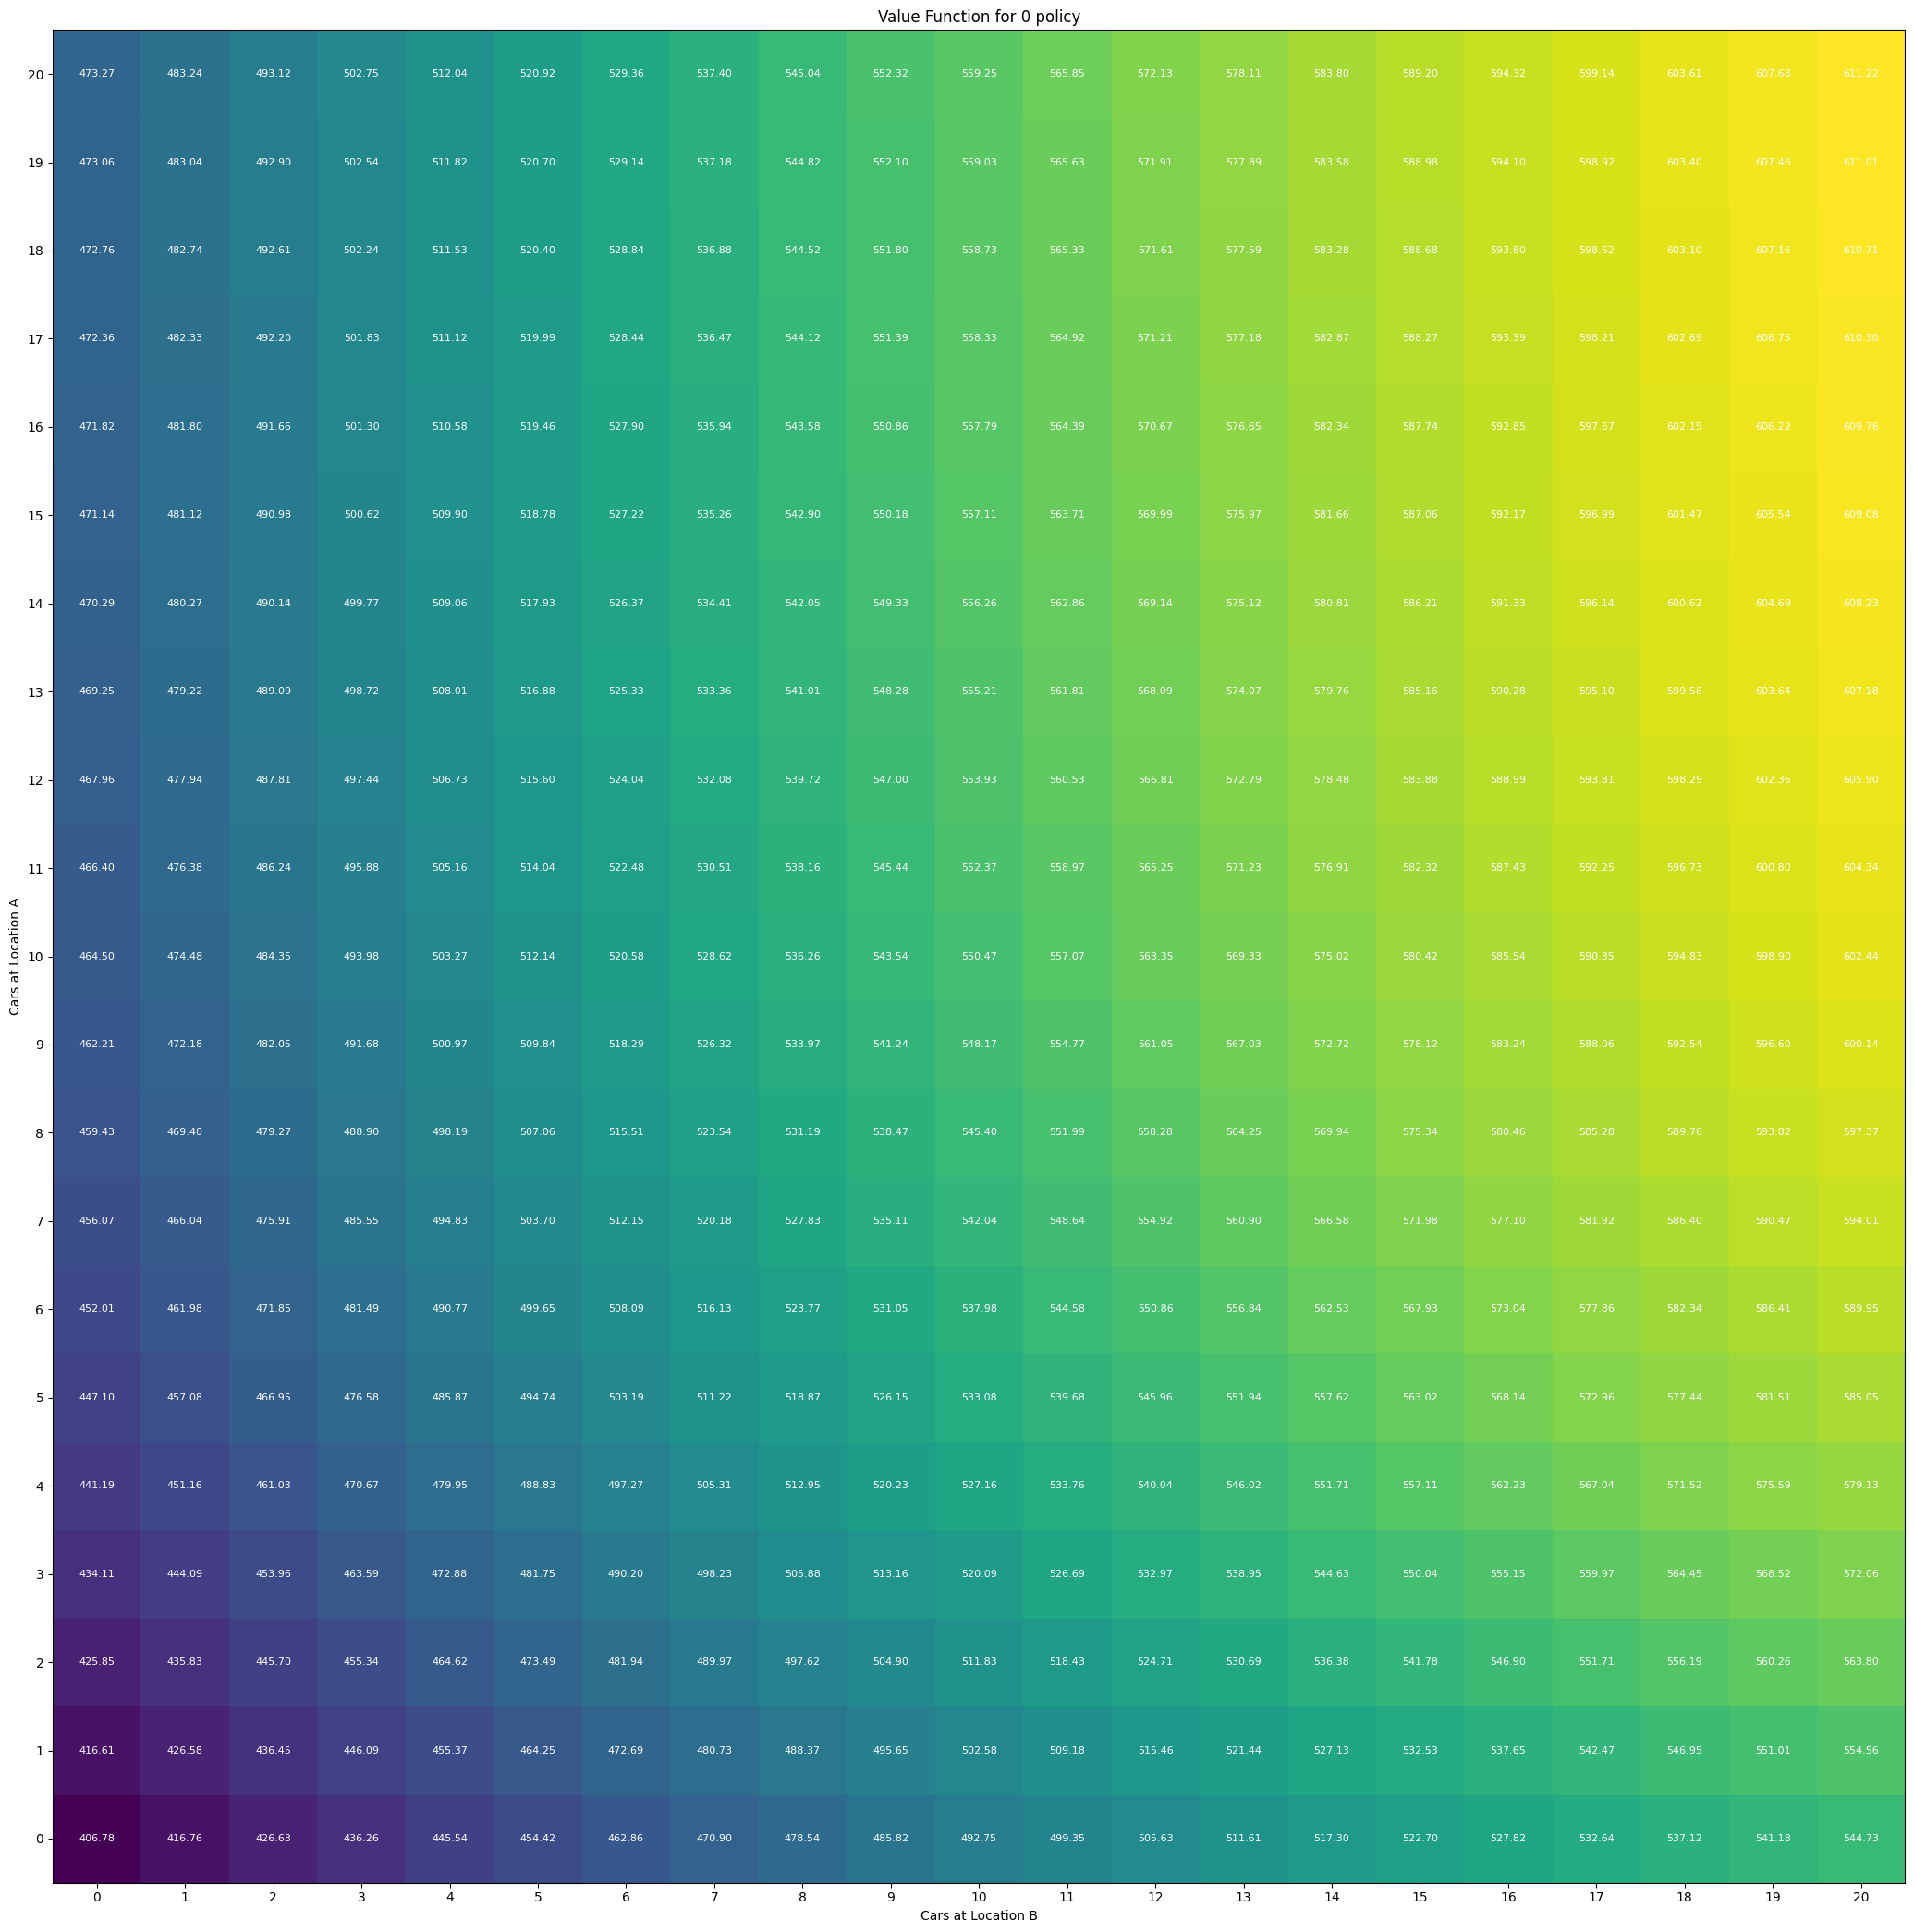

**********Staring 1 iteration


441it [00:00, ?it/s]


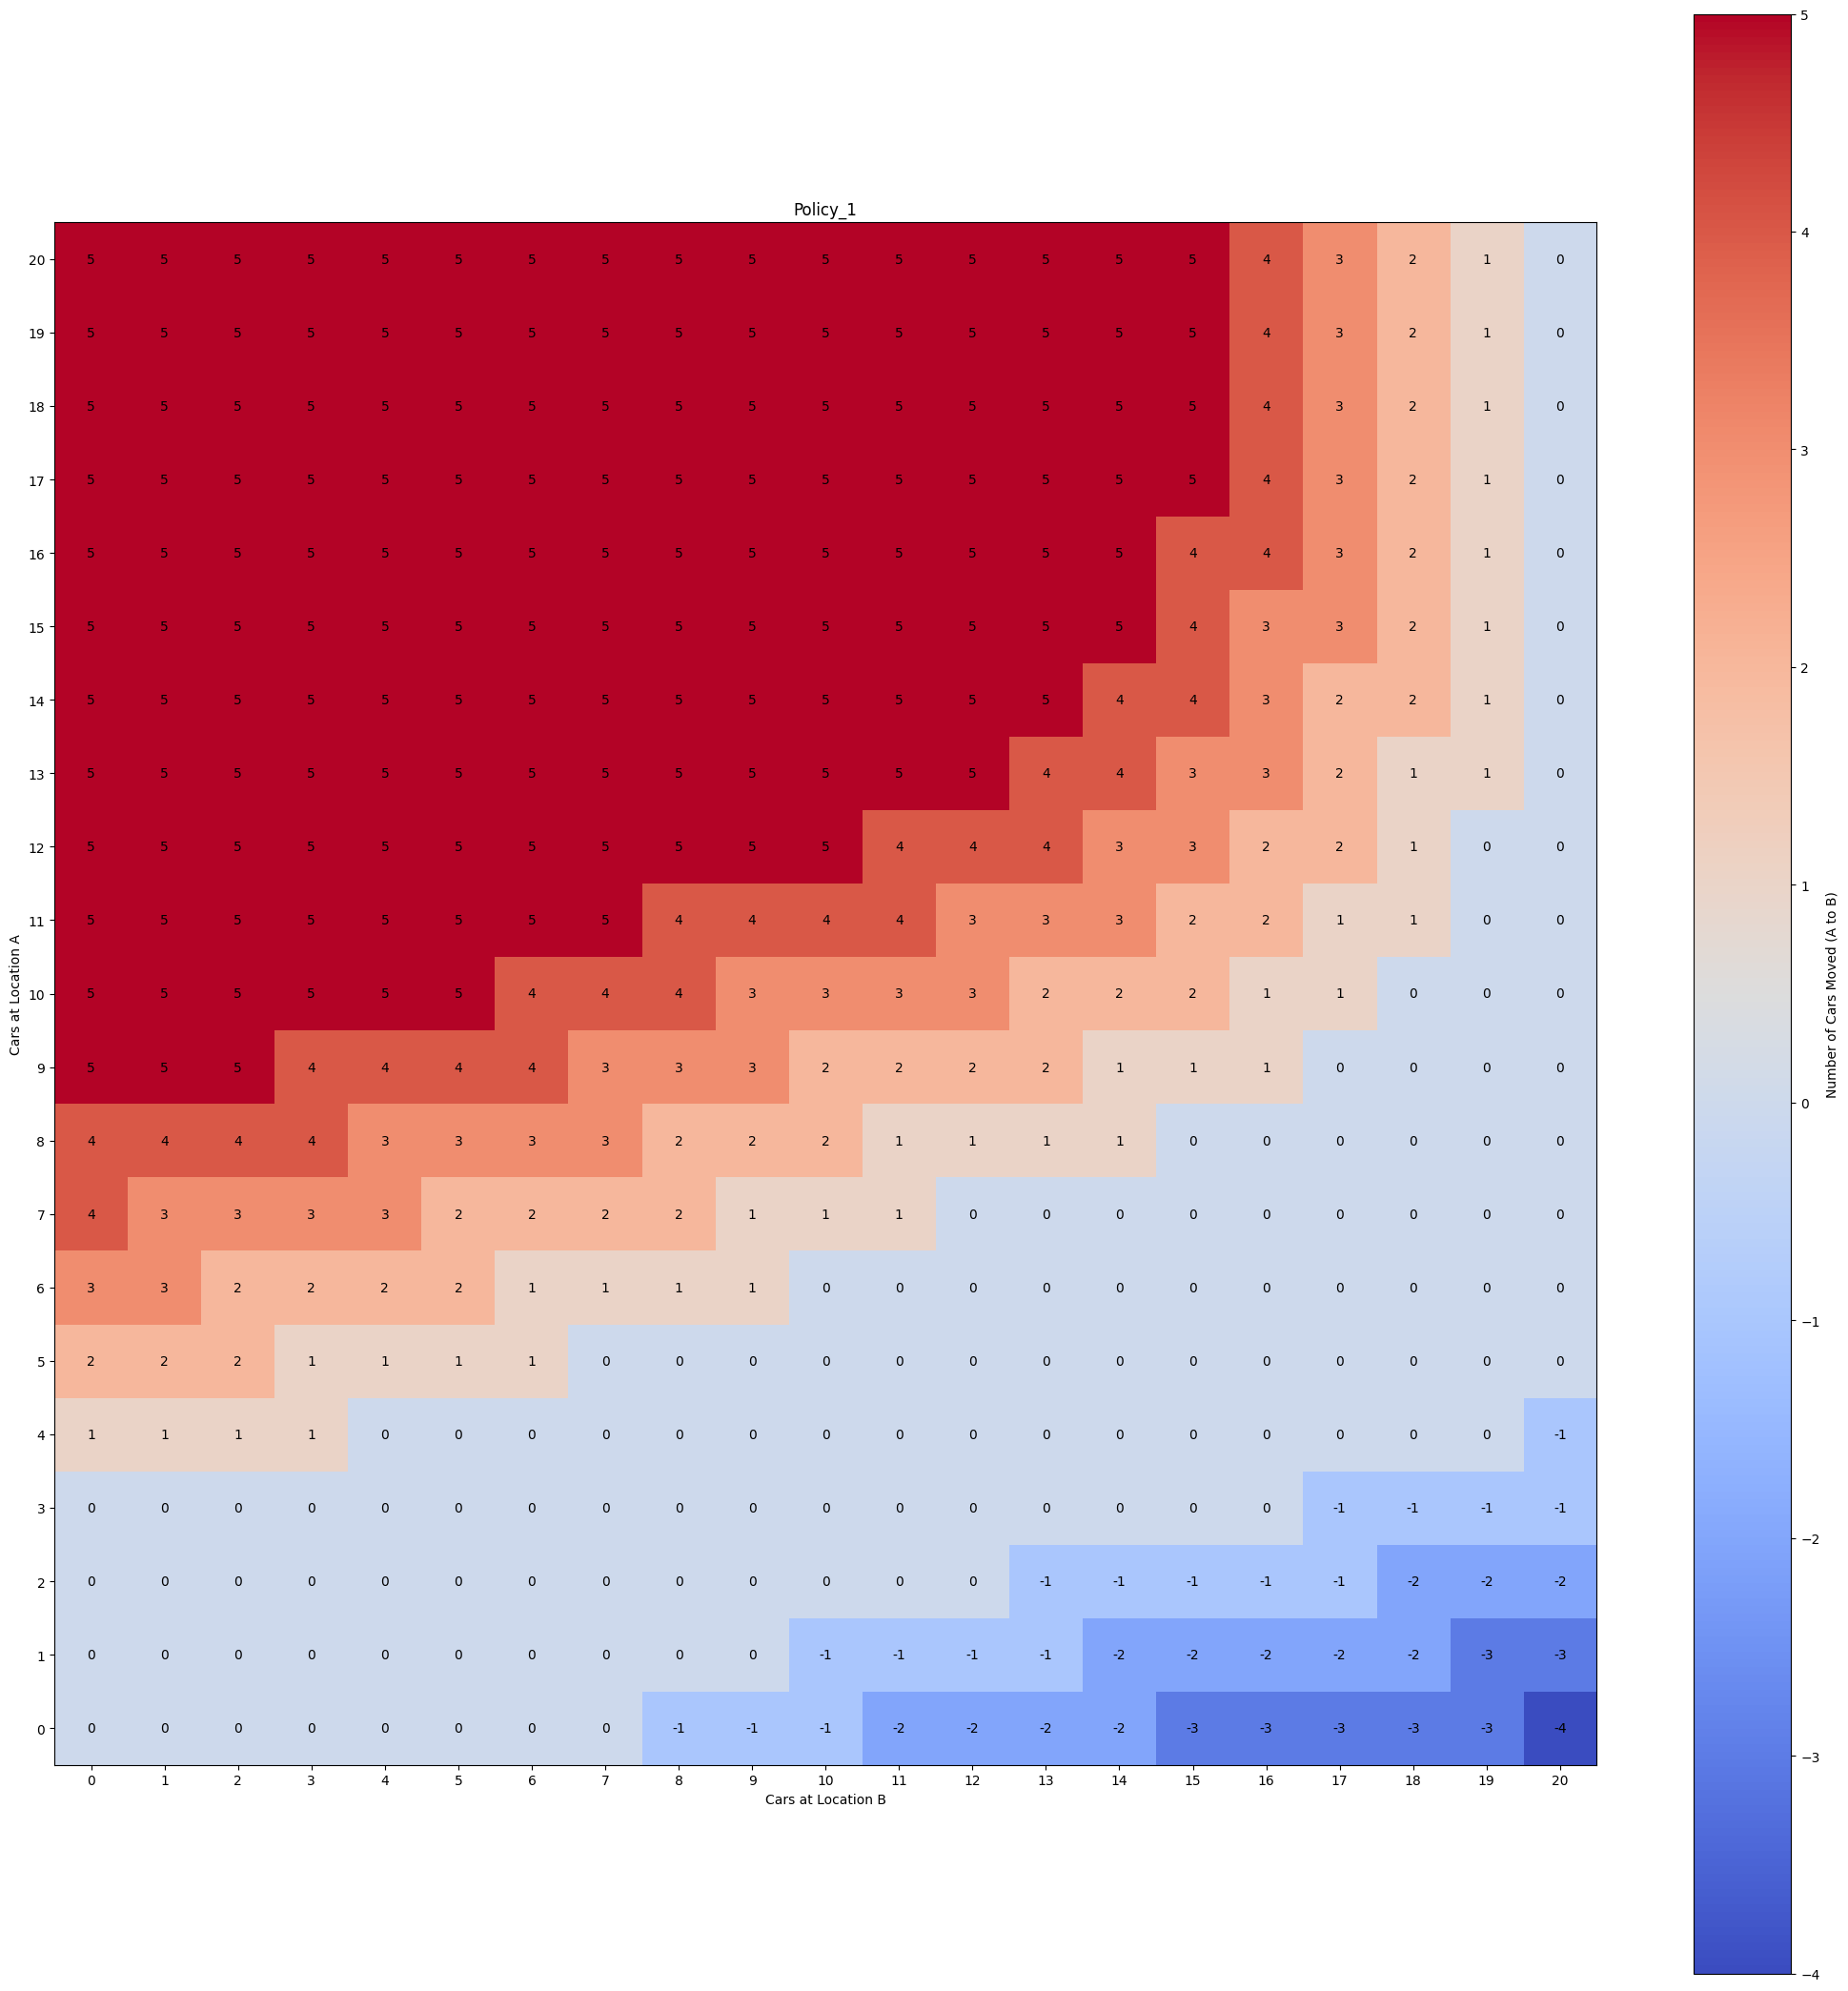

Conduct 1 time evaluation


441it [00:03, 115.70it/s]


50.09924045946781


441it [00:03, 115.83it/s]


3.014762463622901


441it [00:03, 115.34it/s]


1.6973442432547472


441it [00:03, 114.12it/s]


1.3333541028347327


441it [00:03, 115.17it/s]


1.1334209246863338


441it [00:03, 115.48it/s]


0.9464696653791407


441it [00:03, 114.70it/s]


0.7857996115840251


441it [00:03, 114.67it/s]


0.6510032462659865


441it [00:03, 116.03it/s]


0.538817138568902


441it [00:03, 112.37it/s]


0.4457483050284168


441it [00:03, 111.54it/s]


0.3686558166438658


441it [00:03, 111.90it/s]


0.30484789137500456


441it [00:03, 110.57it/s]


0.25205905152614605


441it [00:04, 110.23it/s]


0.20839810702437944


441it [00:03, 112.62it/s]


0.1722927648149266


441it [00:03, 111.34it/s]


0.1424387370602176


441it [00:03, 112.83it/s]


0.11775542500043912


441it [00:03, 112.97it/s]


0.09734823795457714


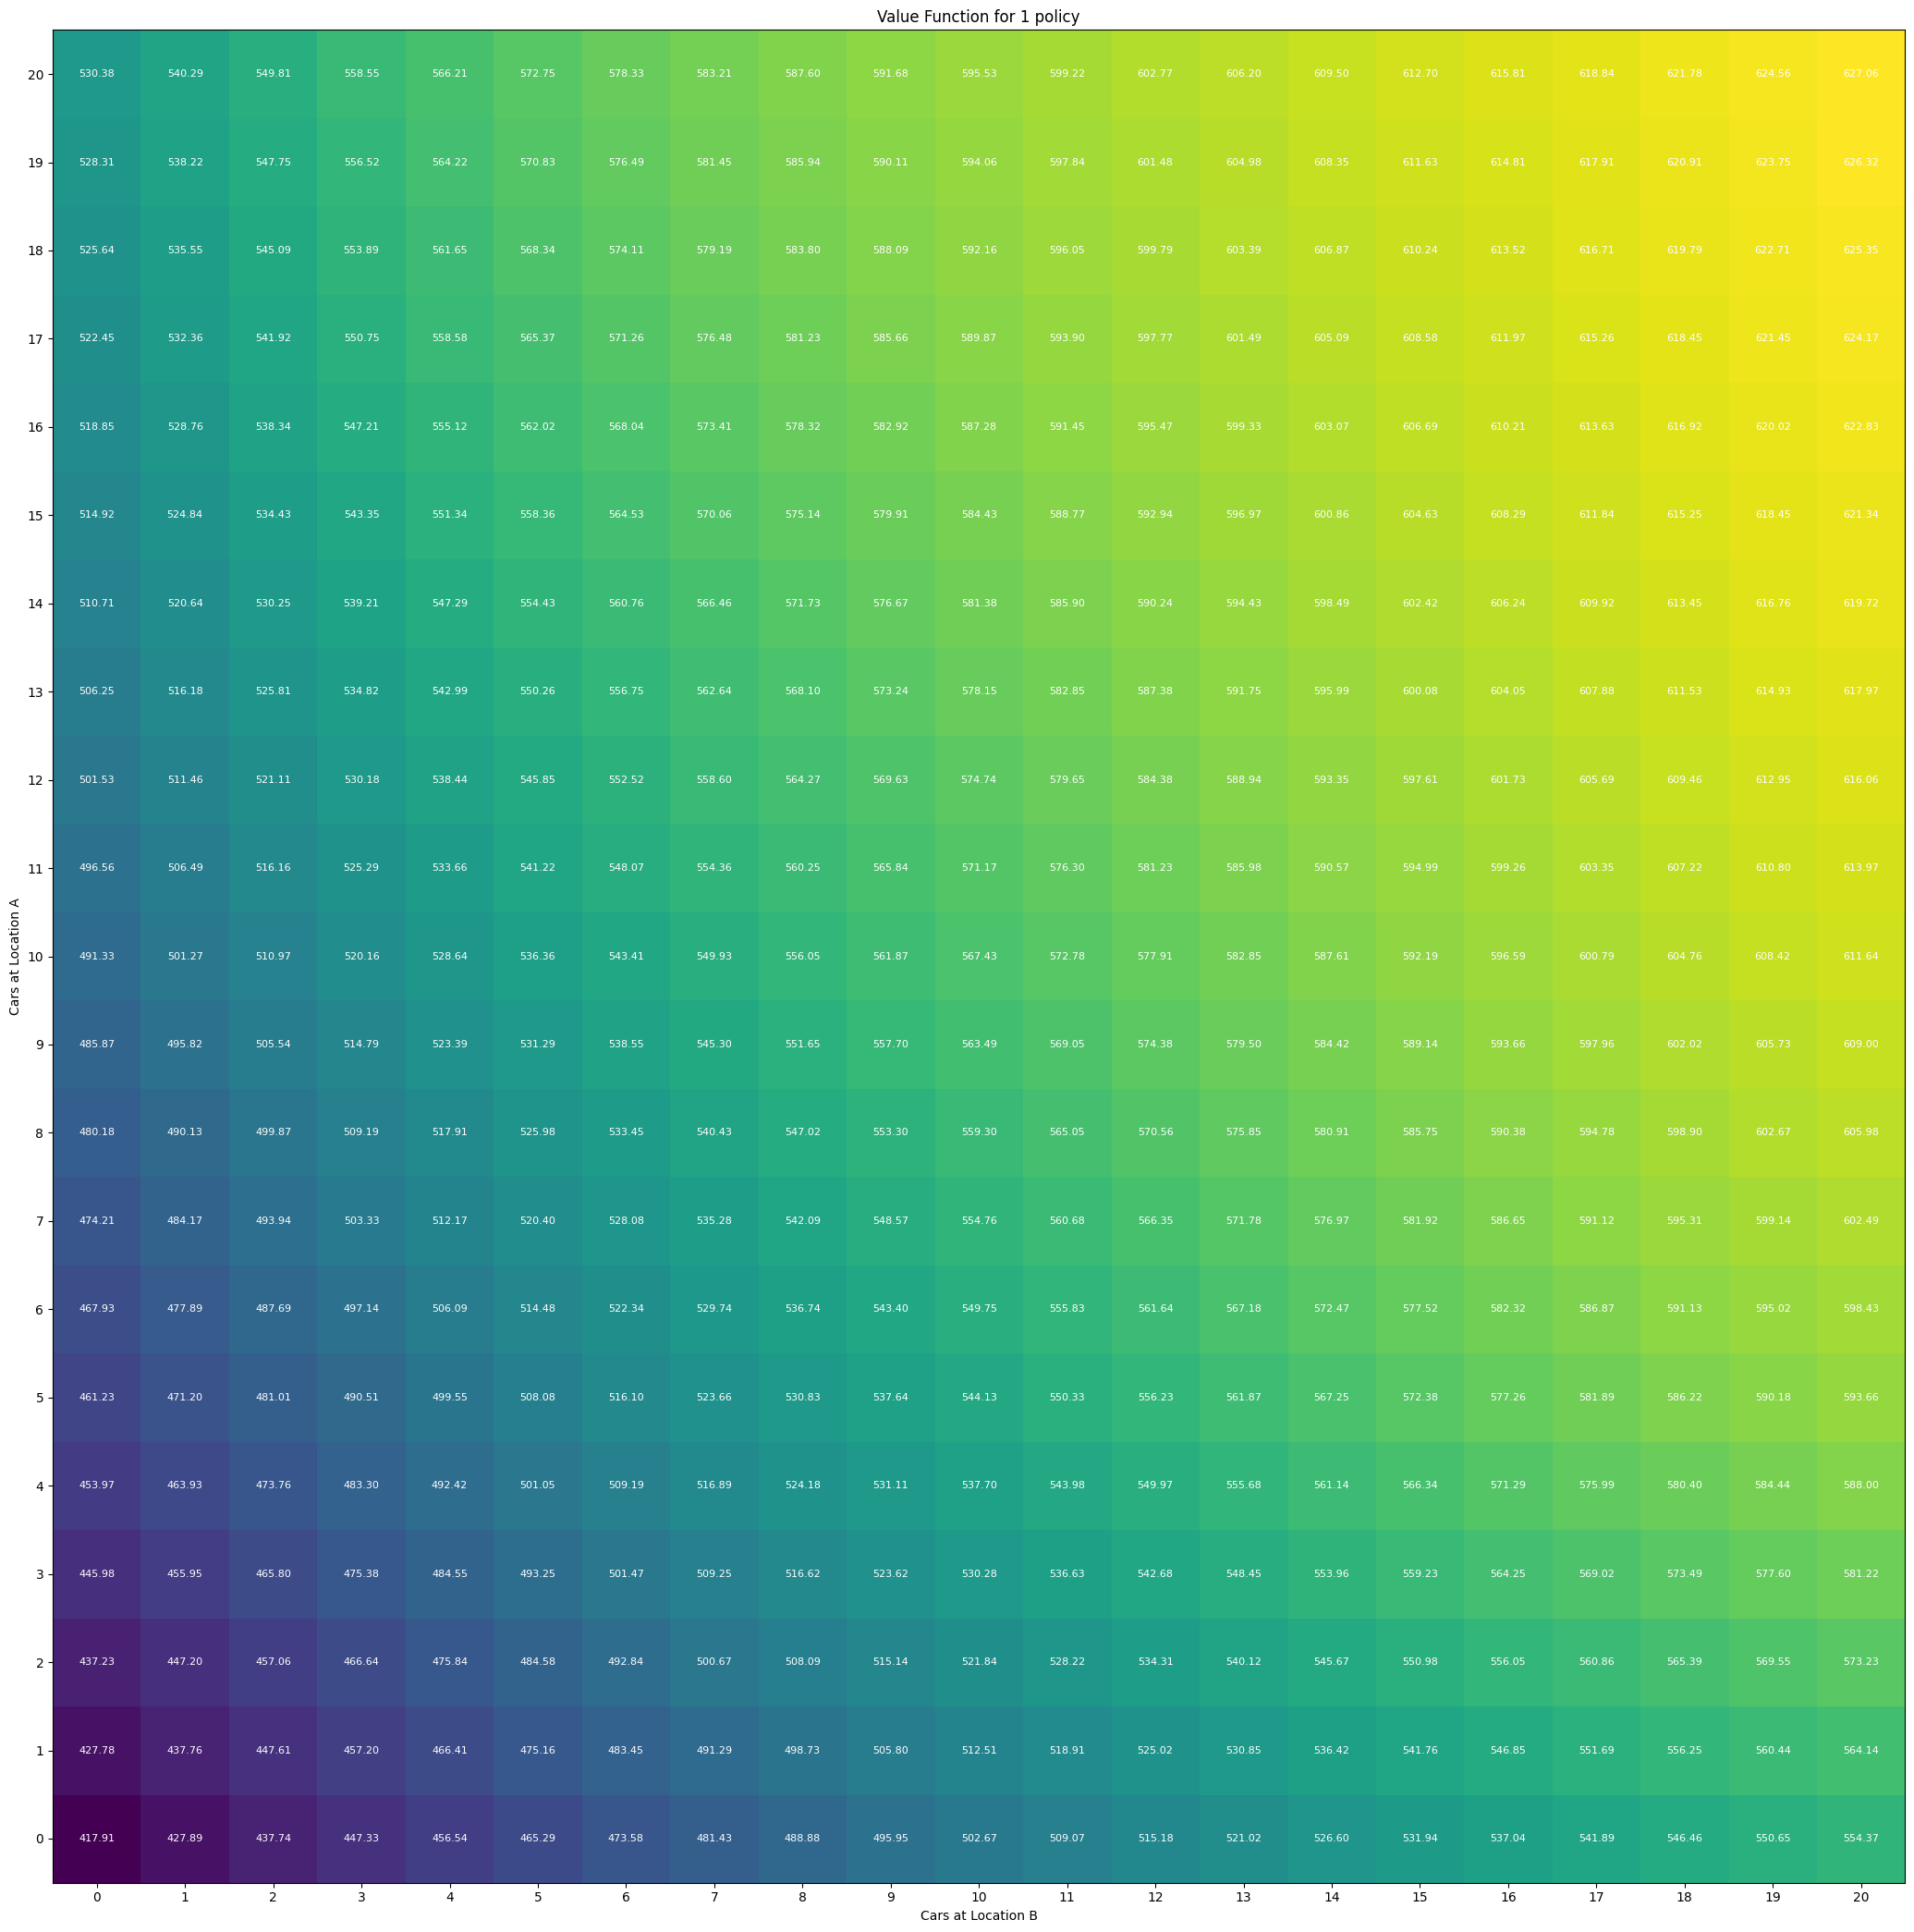

**********Staring 2 iteration


441it [00:00, 220594.88it/s]


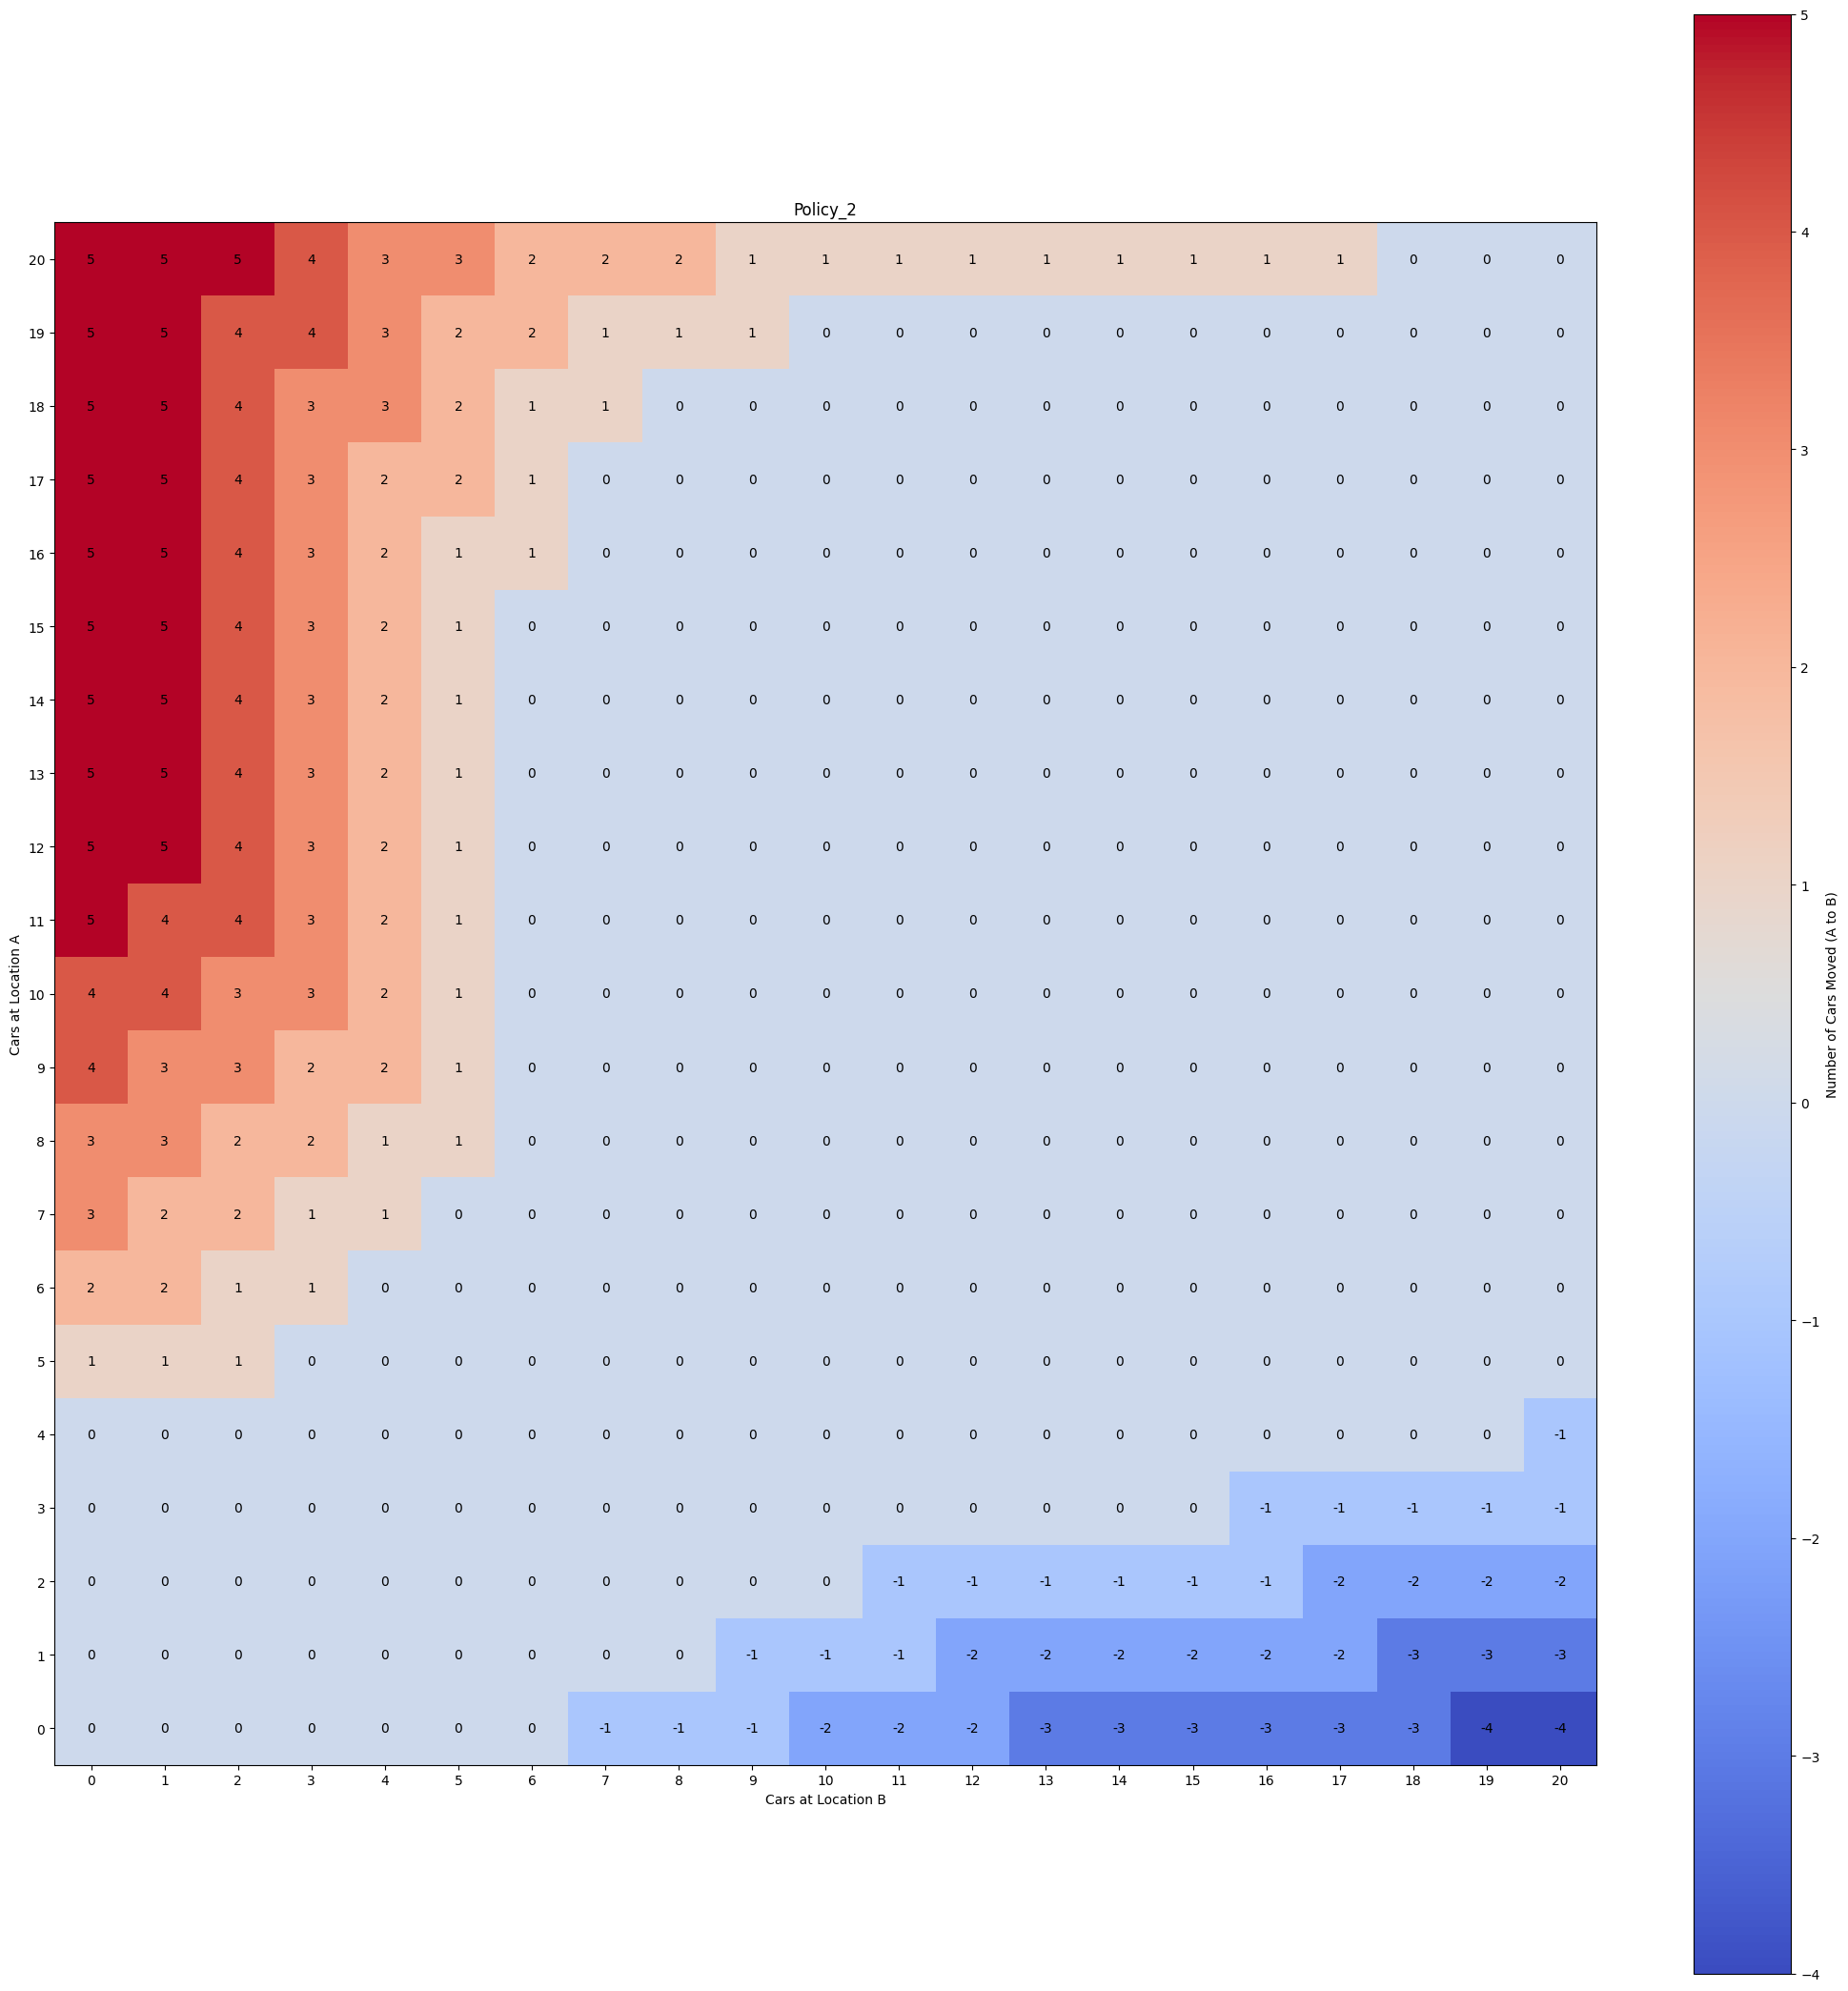

Conduct 2 time evaluation


441it [00:03, 114.06it/s]


4.415074288121559


441it [00:03, 112.20it/s]


2.5533309249658487


441it [00:03, 111.52it/s]


1.7526143636529241


441it [00:03, 114.54it/s]


1.2022474078328287


441it [00:03, 111.55it/s]


0.8032527611429714


441it [00:03, 111.39it/s]


0.5333572429764217


441it [00:03, 112.63it/s]


0.3589108565446395


441it [00:03, 112.35it/s]


0.26445265641768856


441it [00:03, 111.48it/s]


0.20010771451666187


441it [00:03, 111.64it/s]


0.15386774122180213


441it [00:03, 112.57it/s]


0.1261949027900755


441it [00:04, 109.81it/s]


0.10426702799247778


441it [00:03, 111.01it/s]


0.08604821802714469


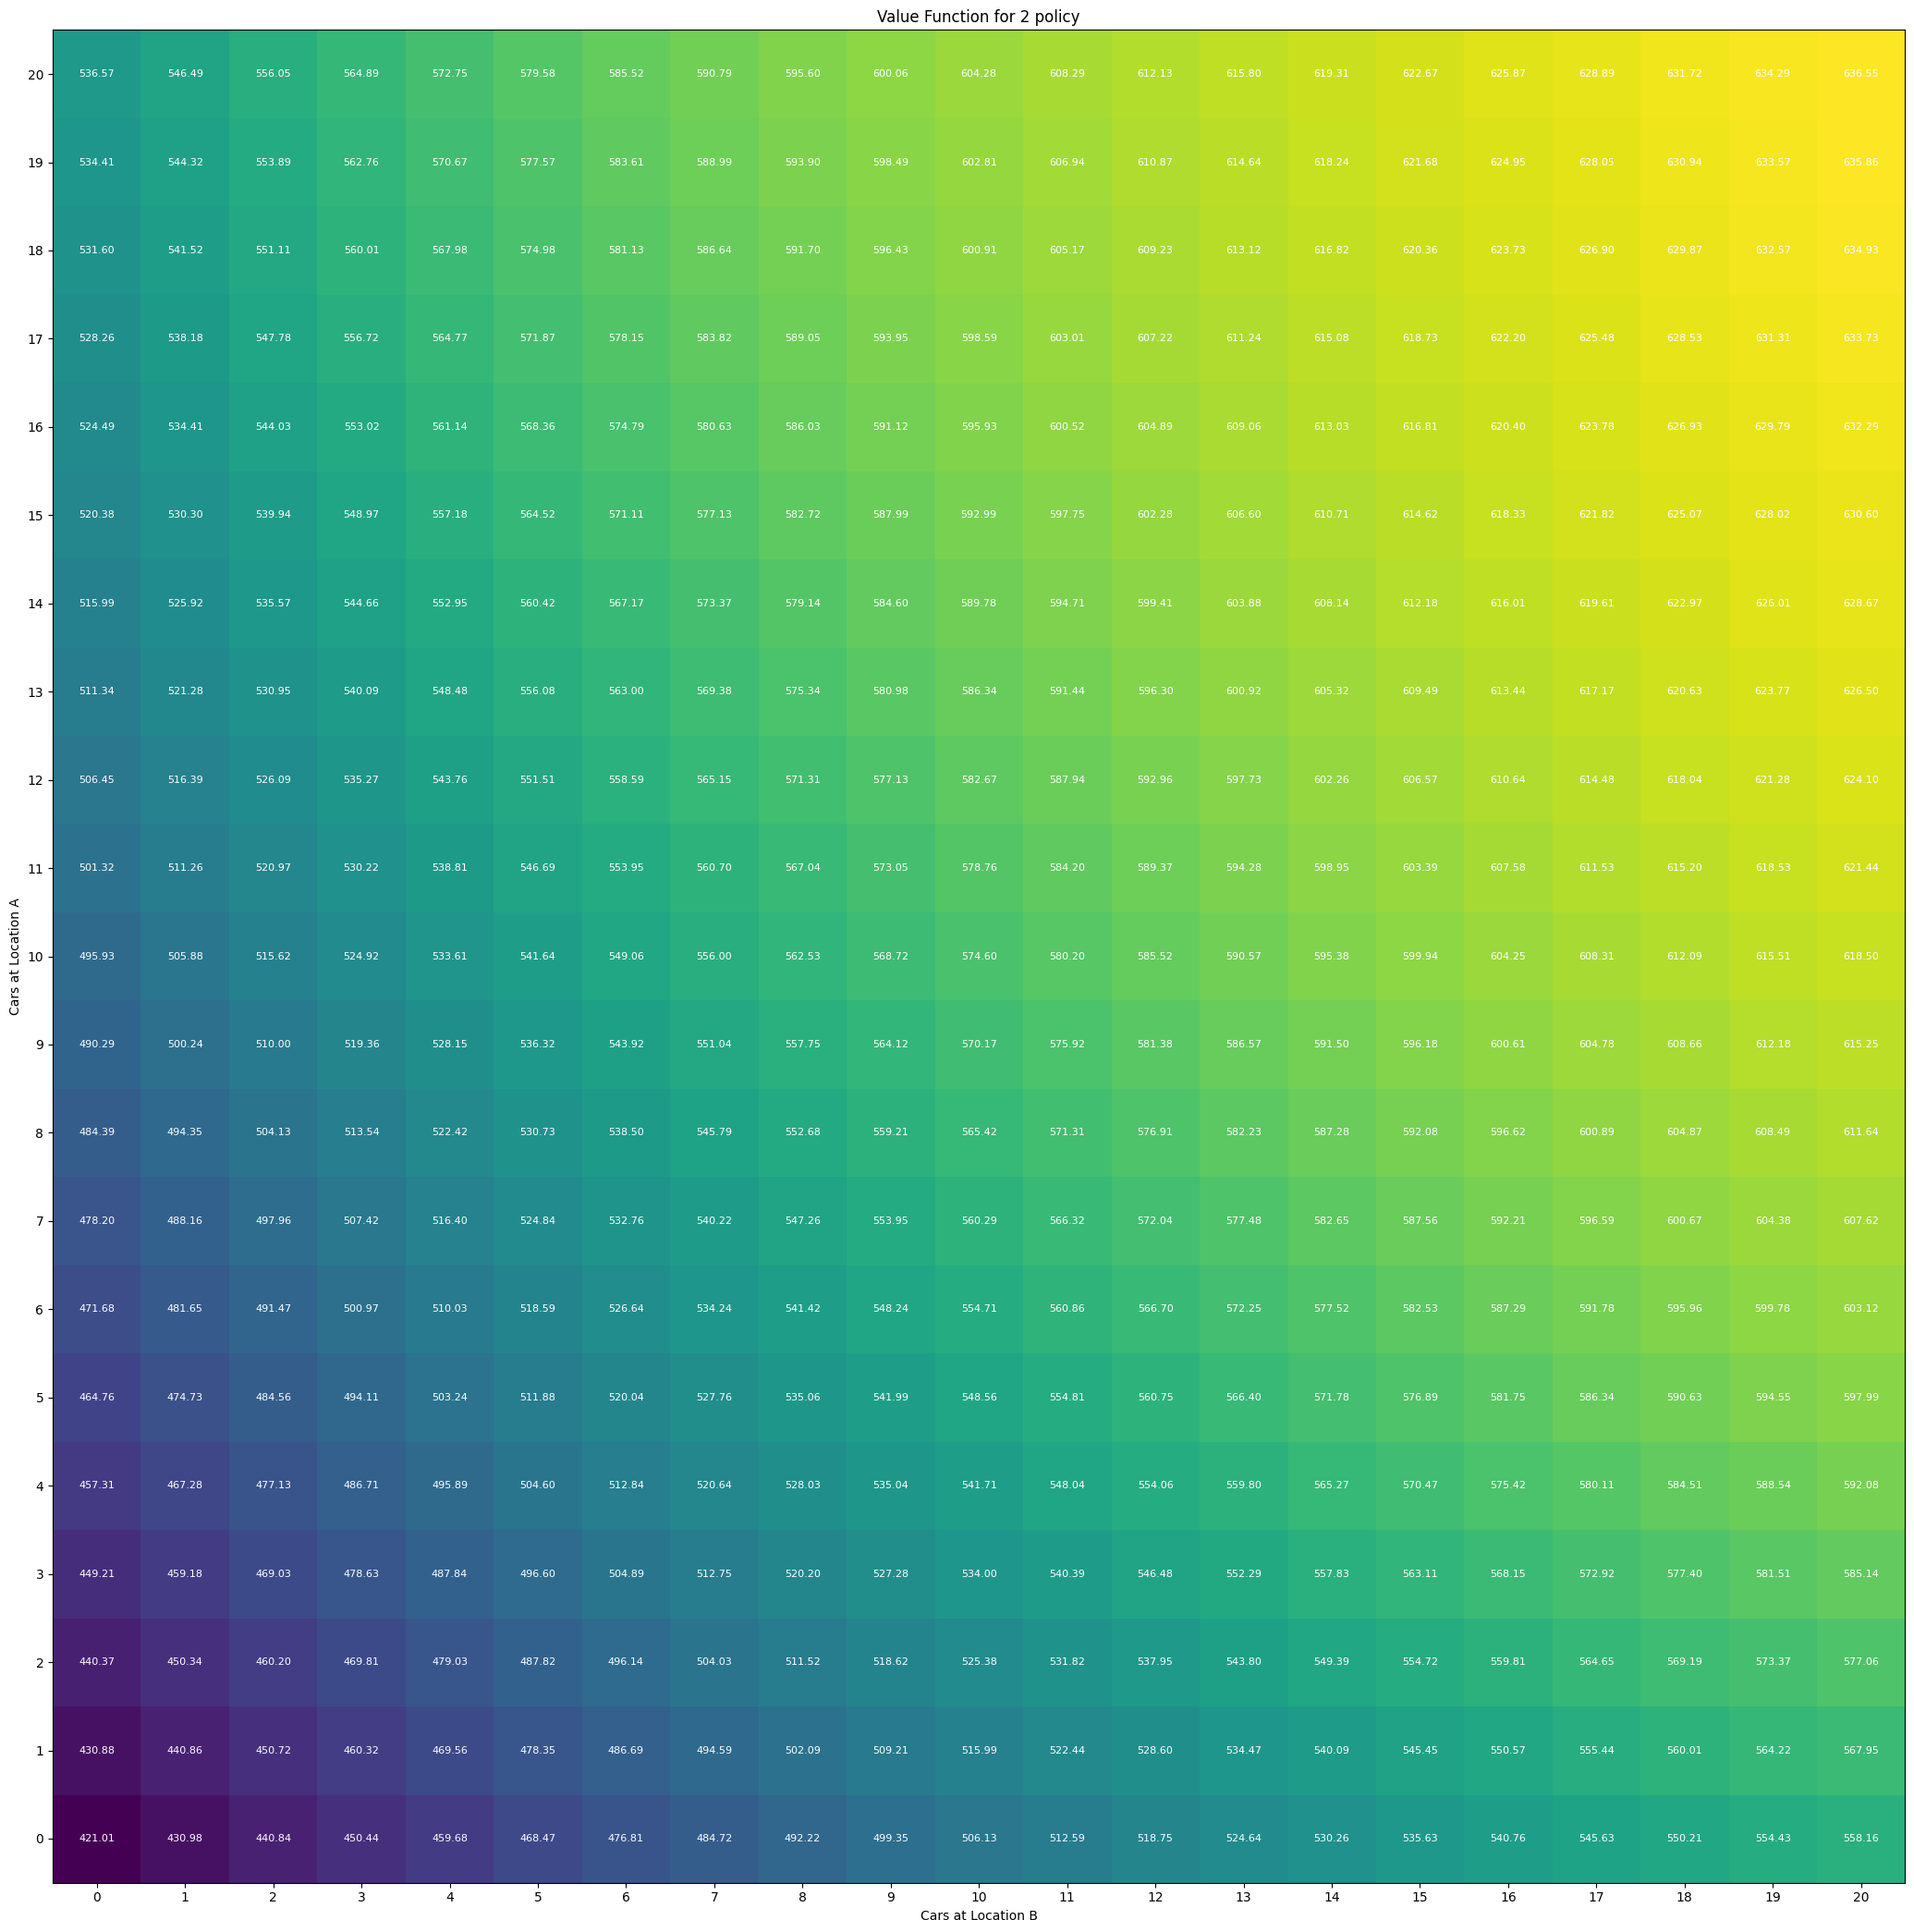

**********Staring 3 iteration


441it [00:00, ?it/s]


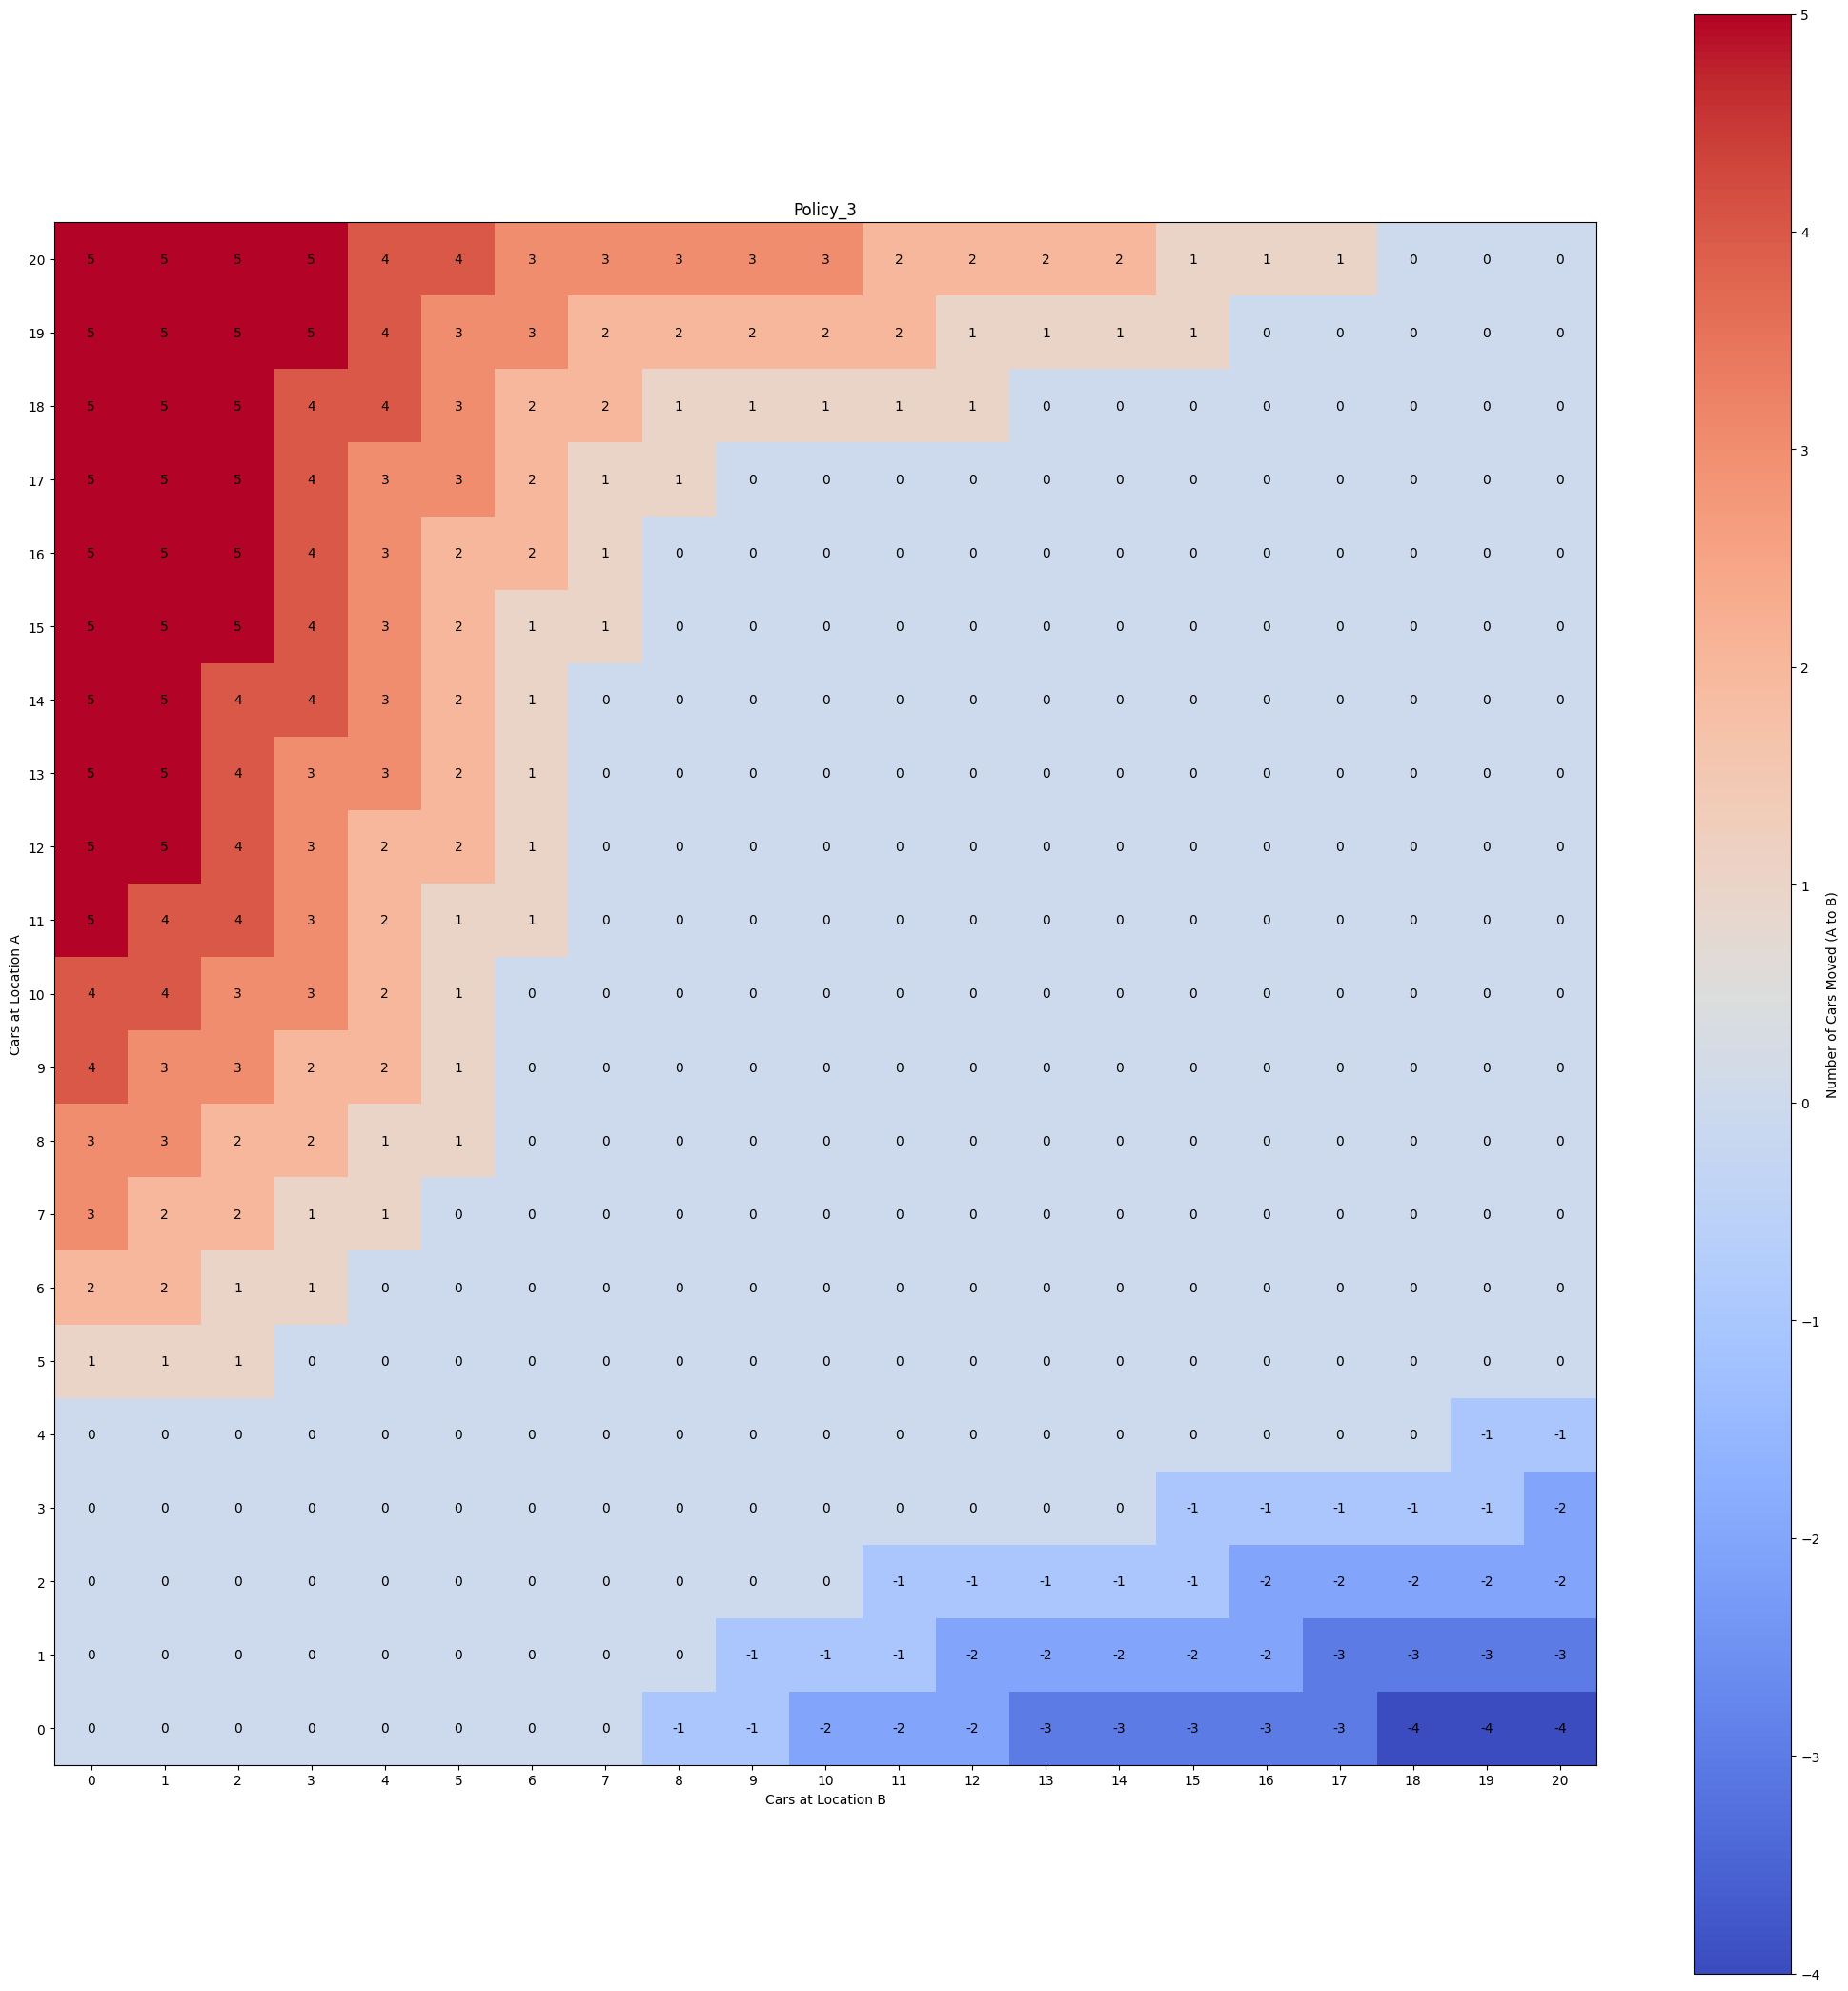

Conduct 3 time evaluation


441it [00:04, 108.91it/s]


0.33441359879668653


441it [00:04, 108.84it/s]


0.116641693090628


441it [00:04, 109.65it/s]


0.07836965047215472


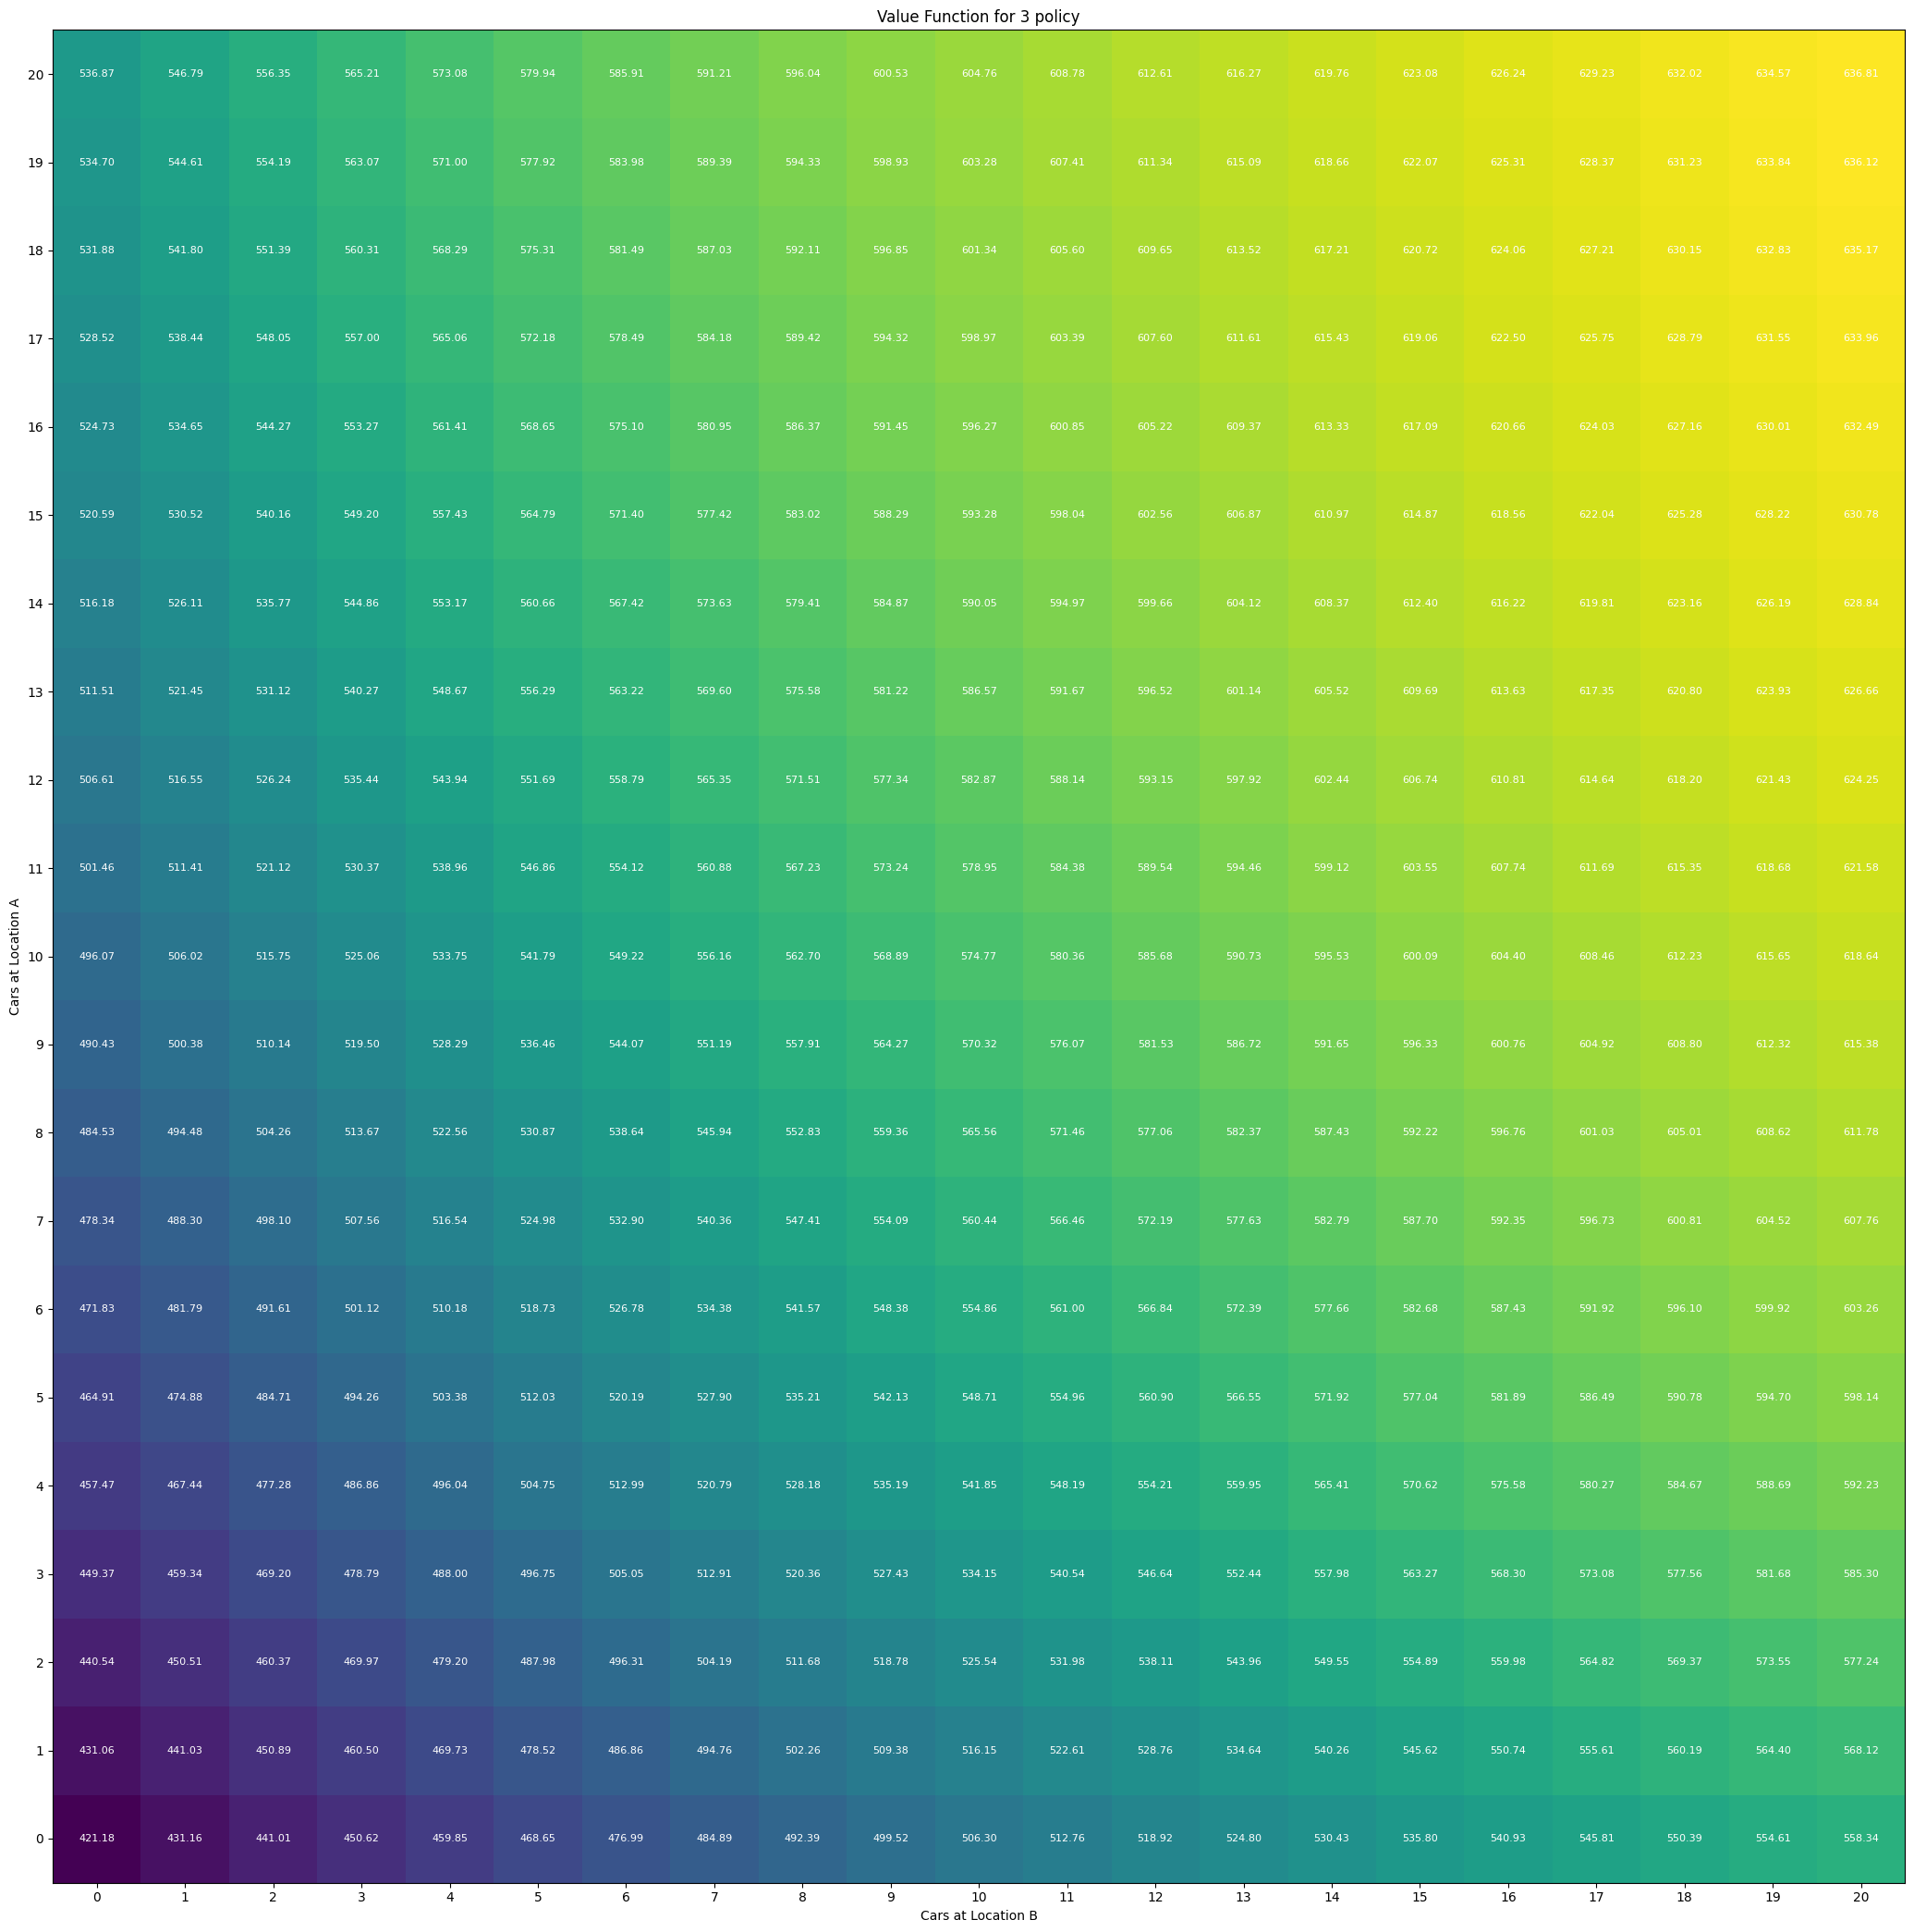

**********Staring 4 iteration


441it [00:00, 270145.77it/s]


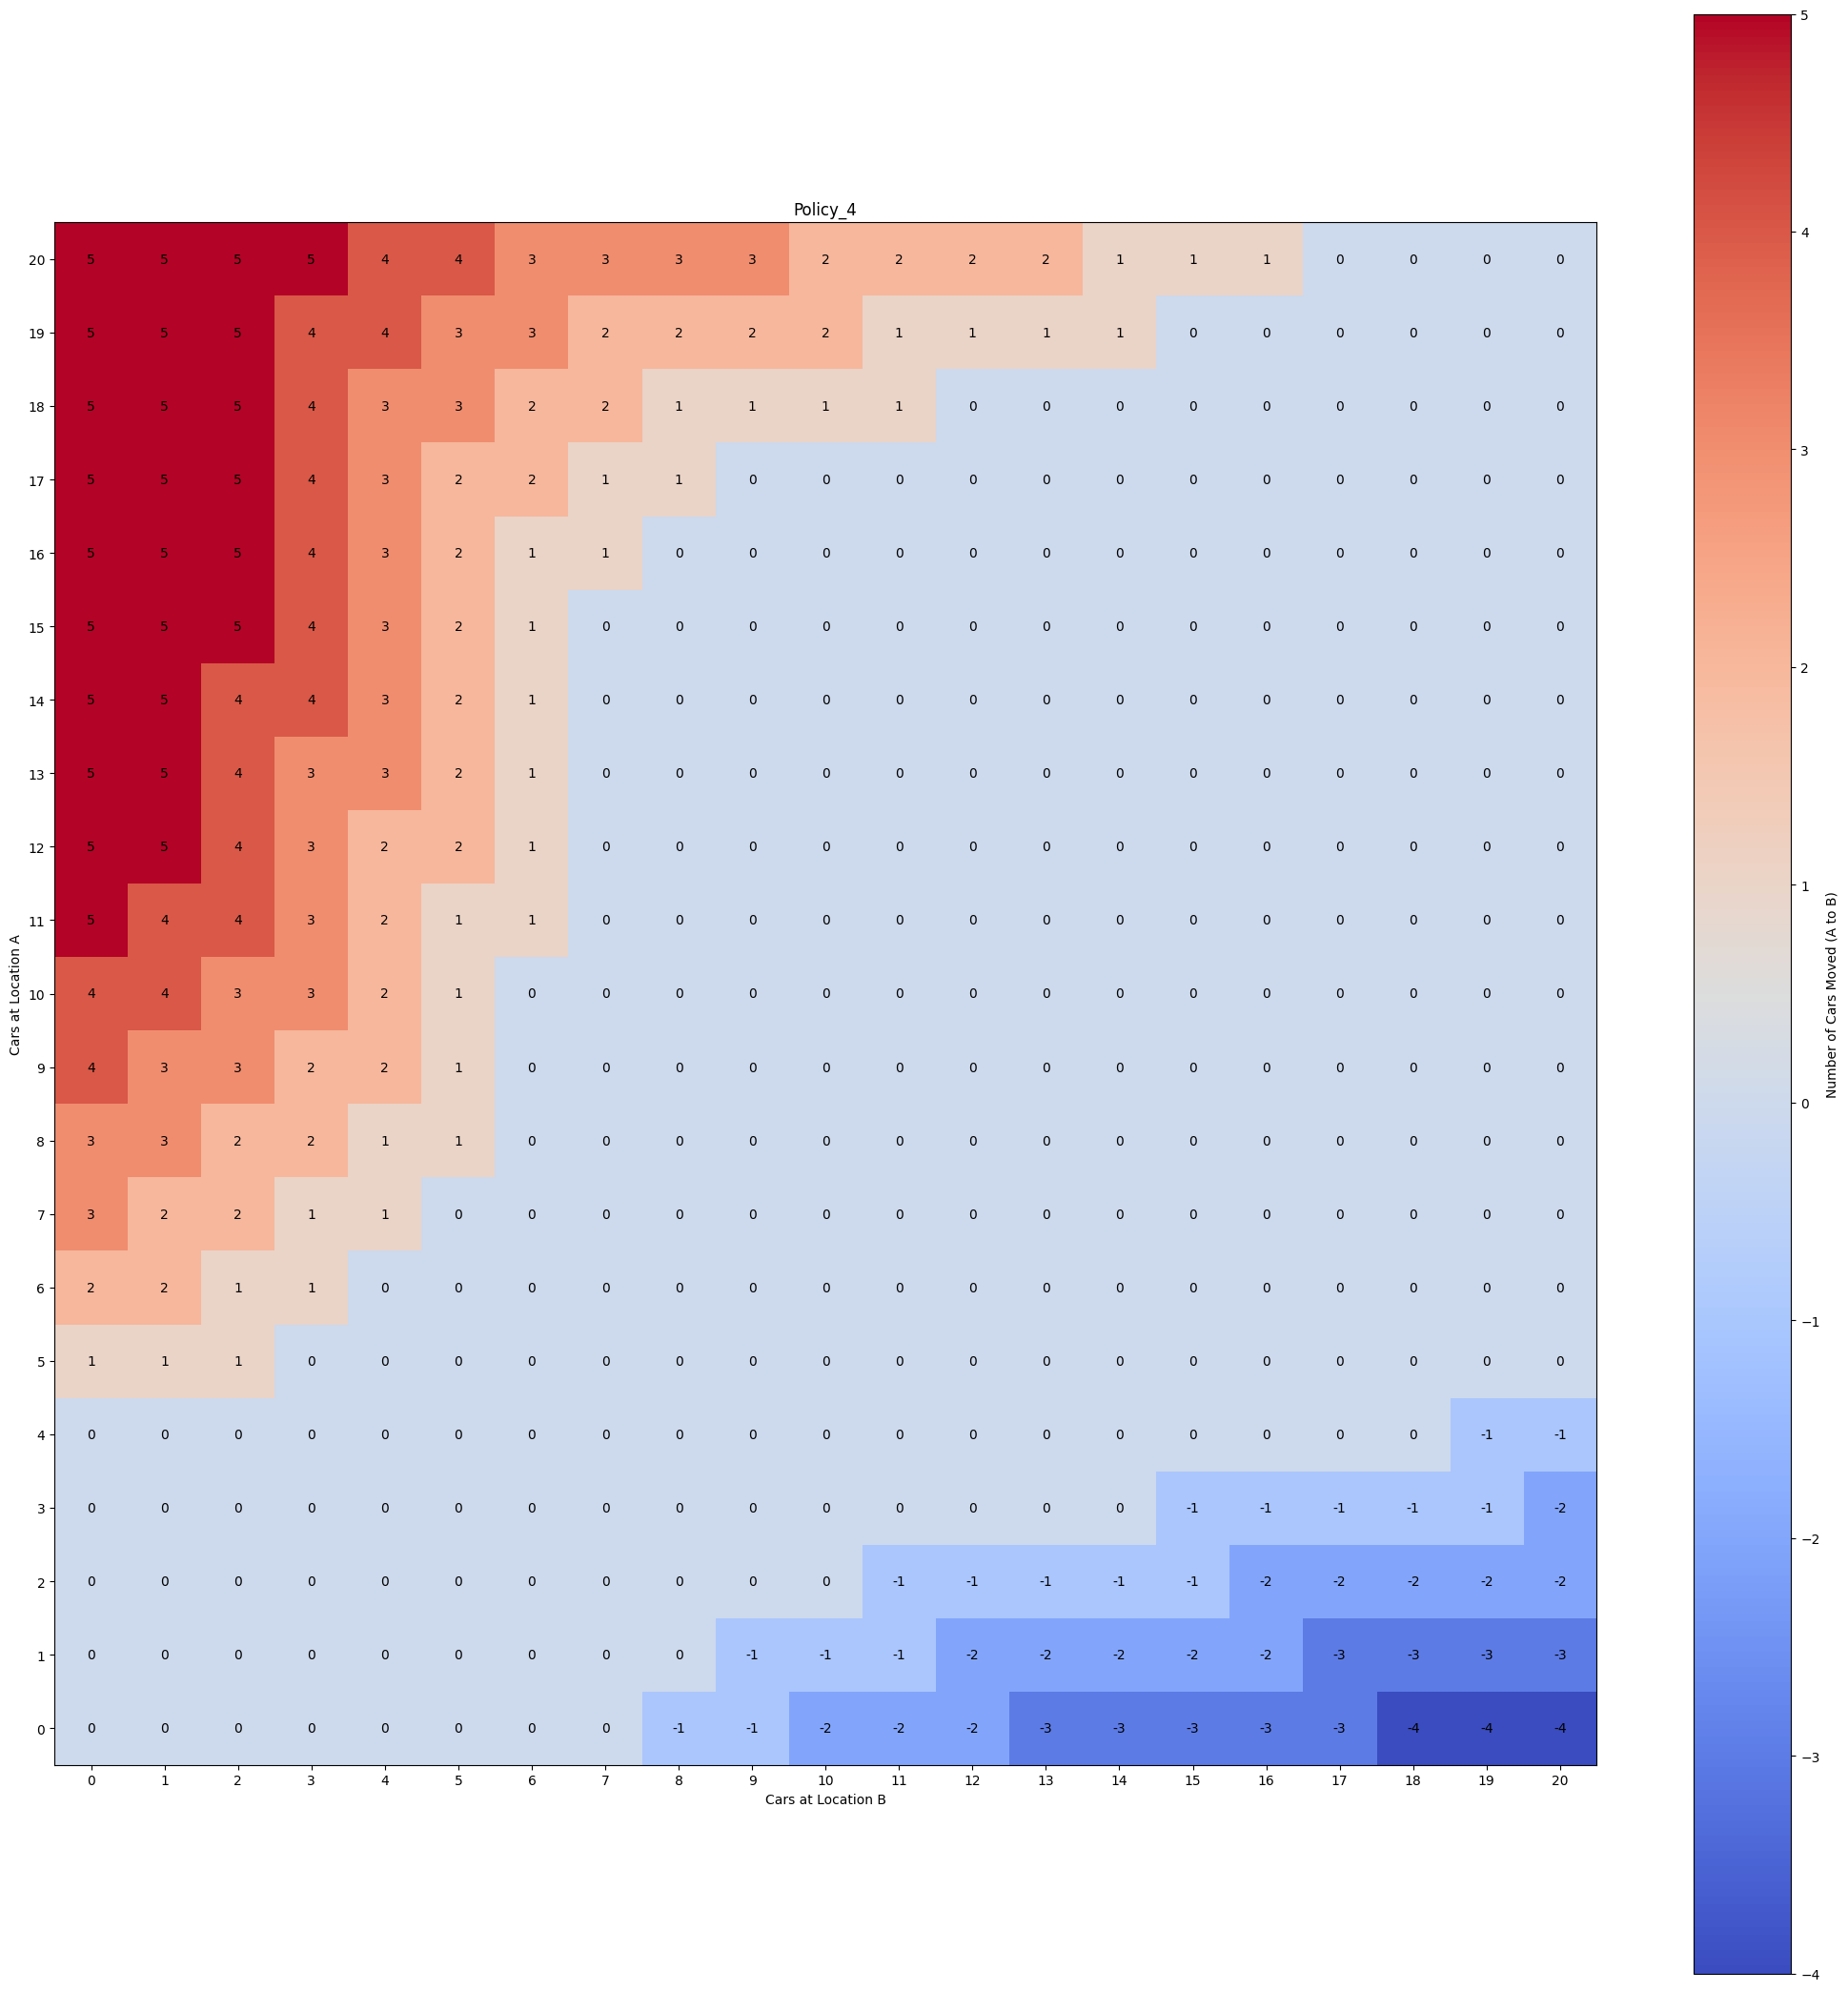

Conduct 4 time evaluation


441it [00:04, 109.06it/s]


0.056079832338127744


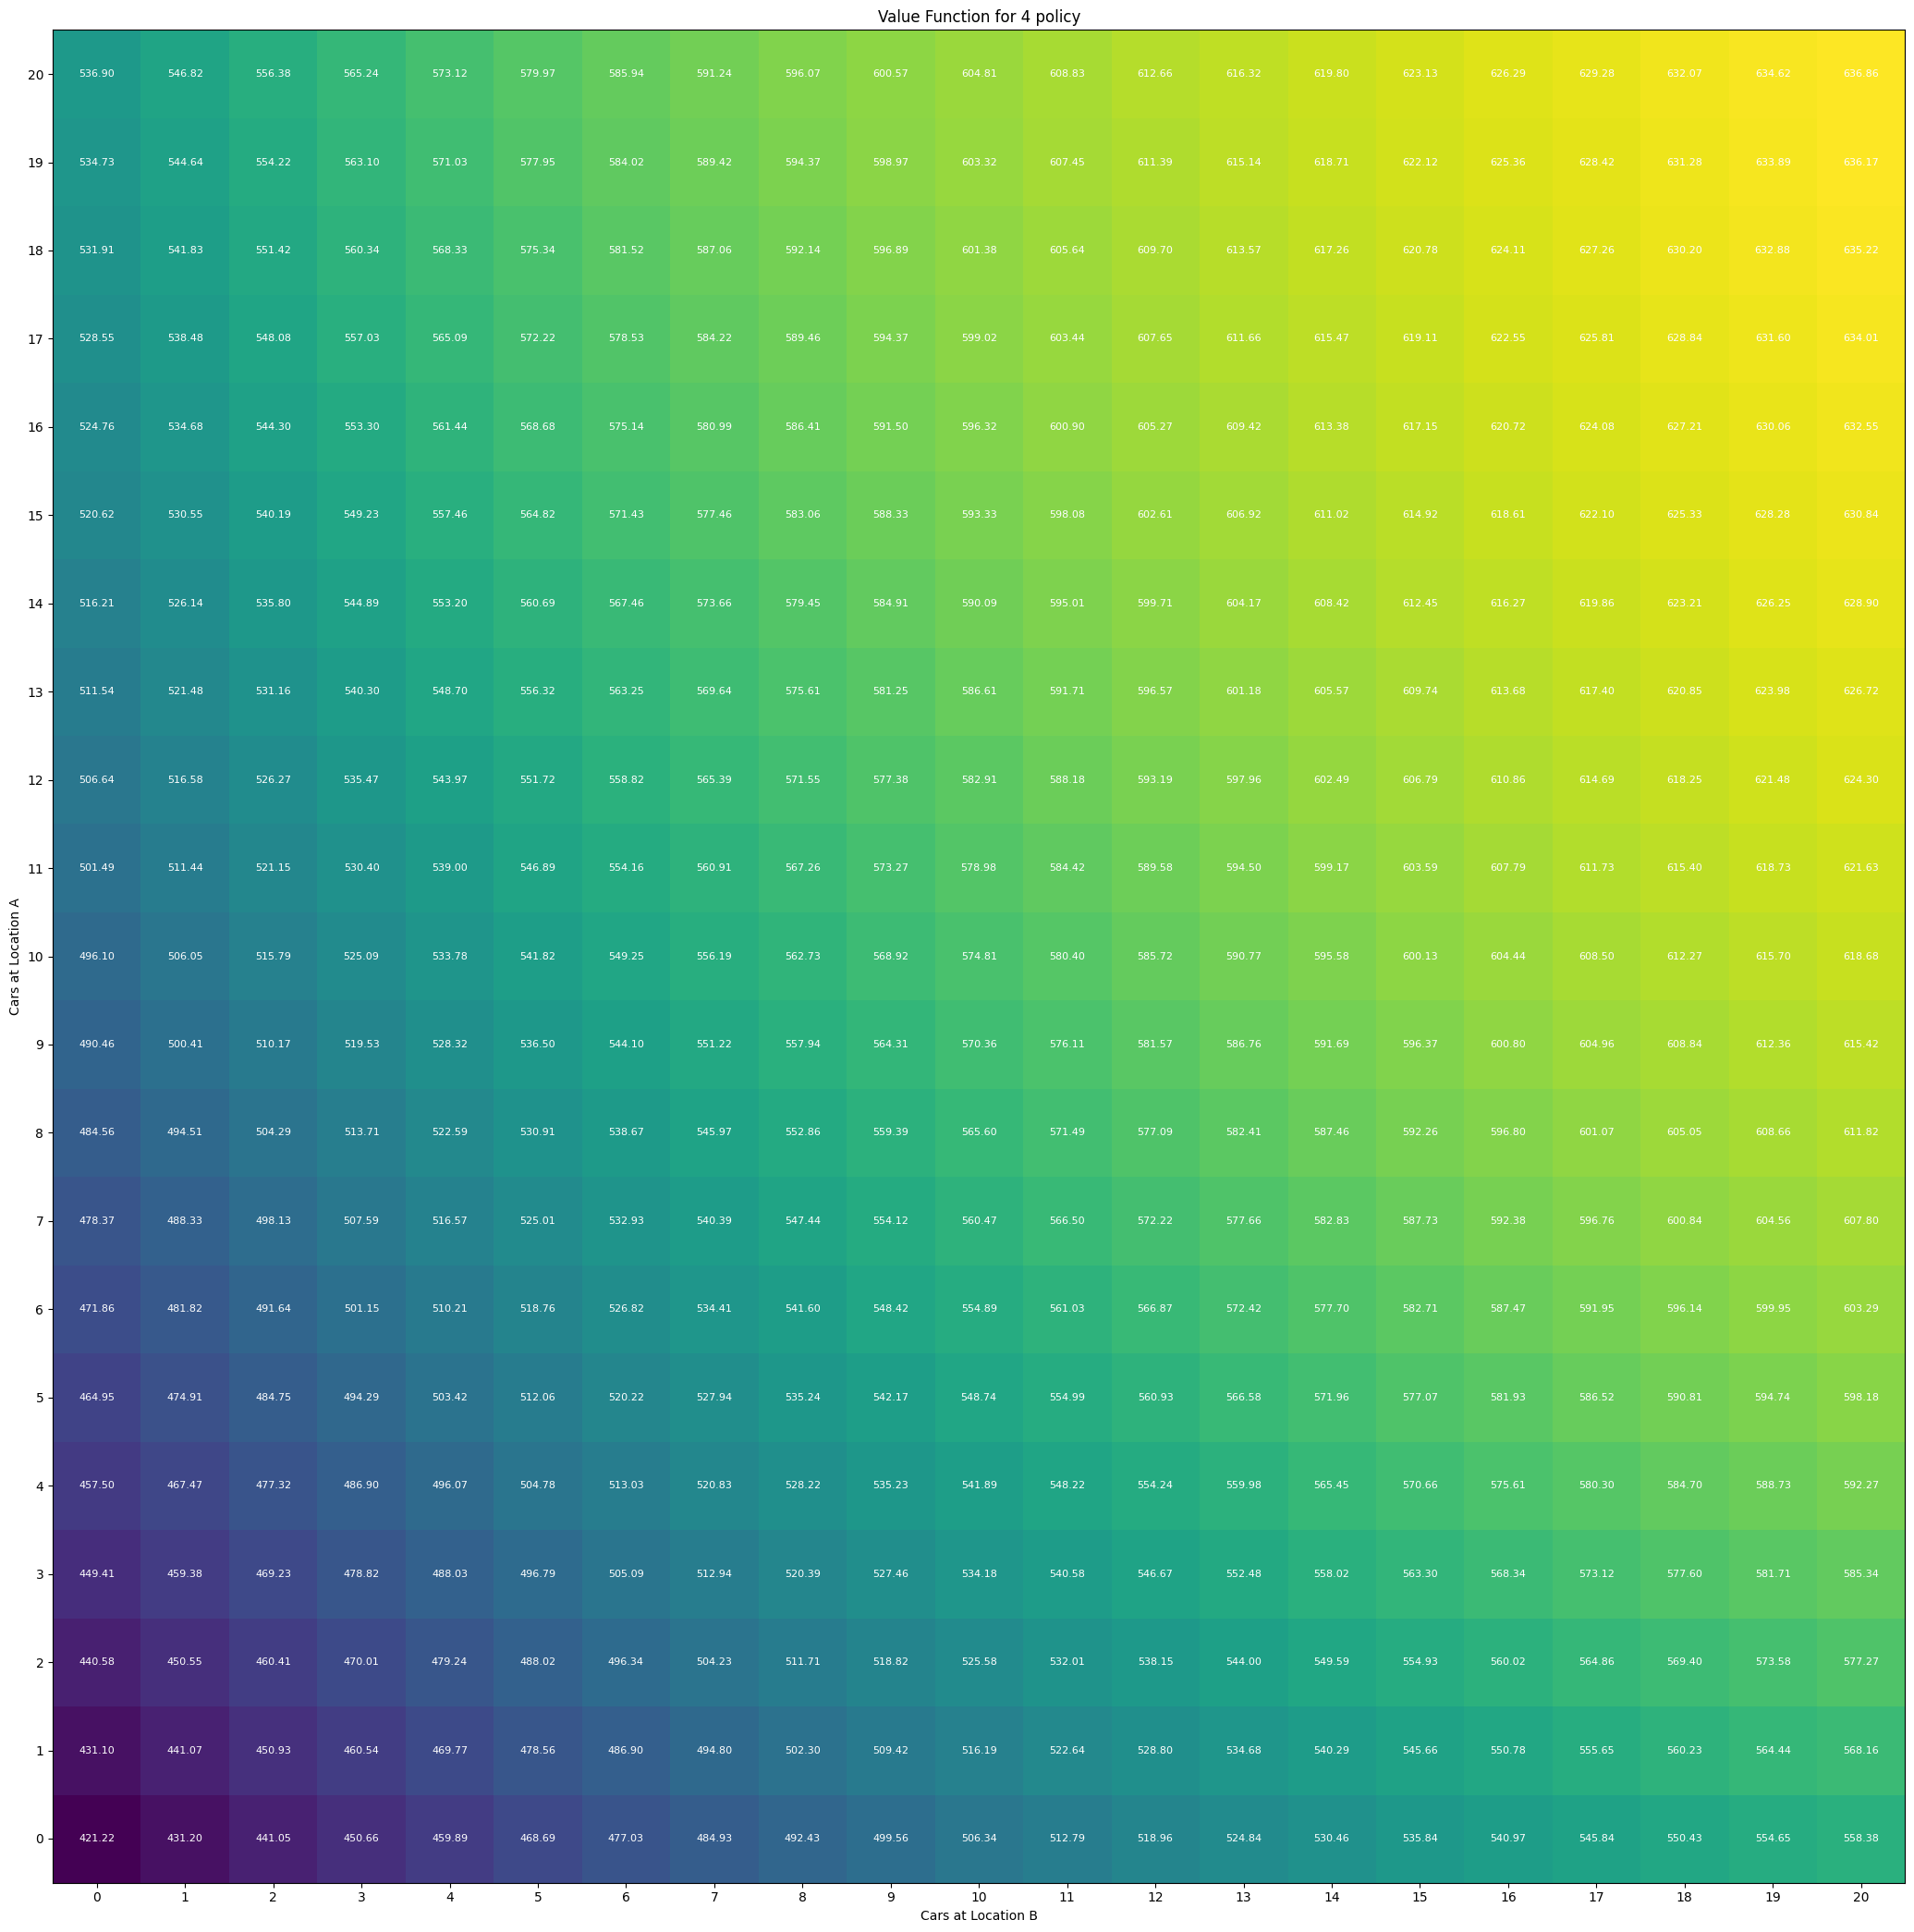

**********Staring 5 iteration


441it [00:00, ?it/s]


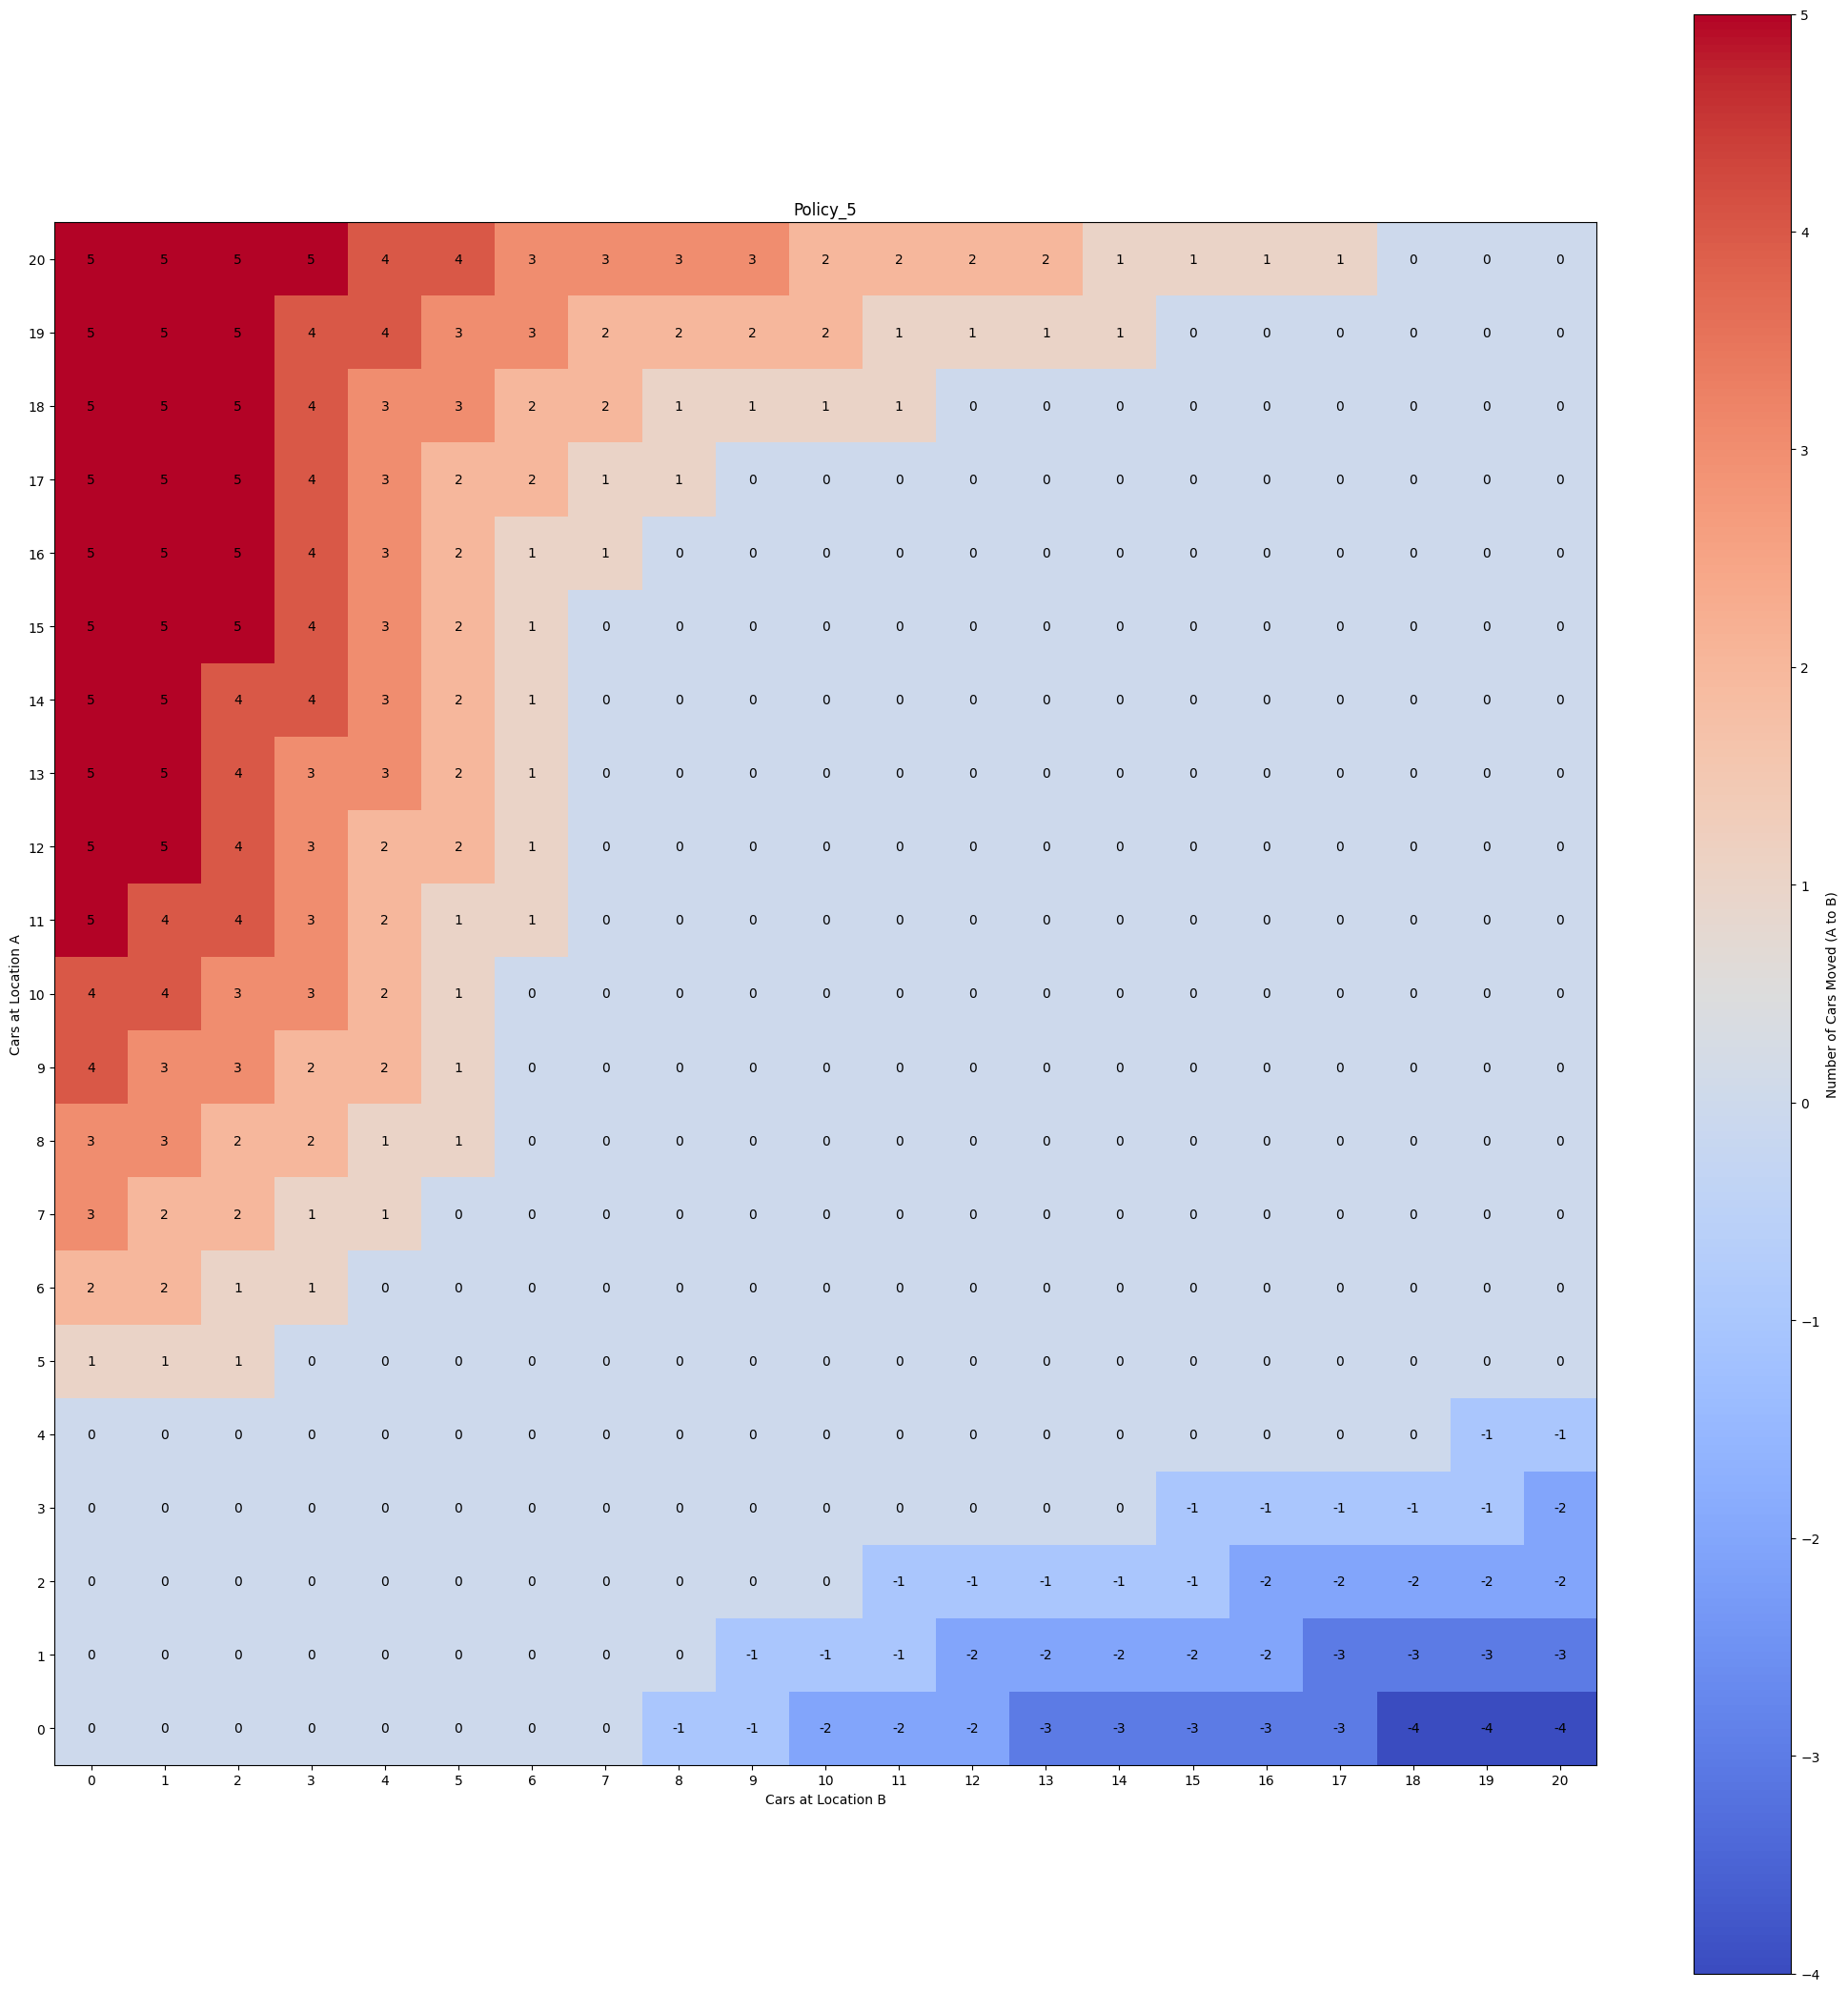

Conduct 5 time evaluation


441it [00:03, 113.41it/s]


0.04043658371892889


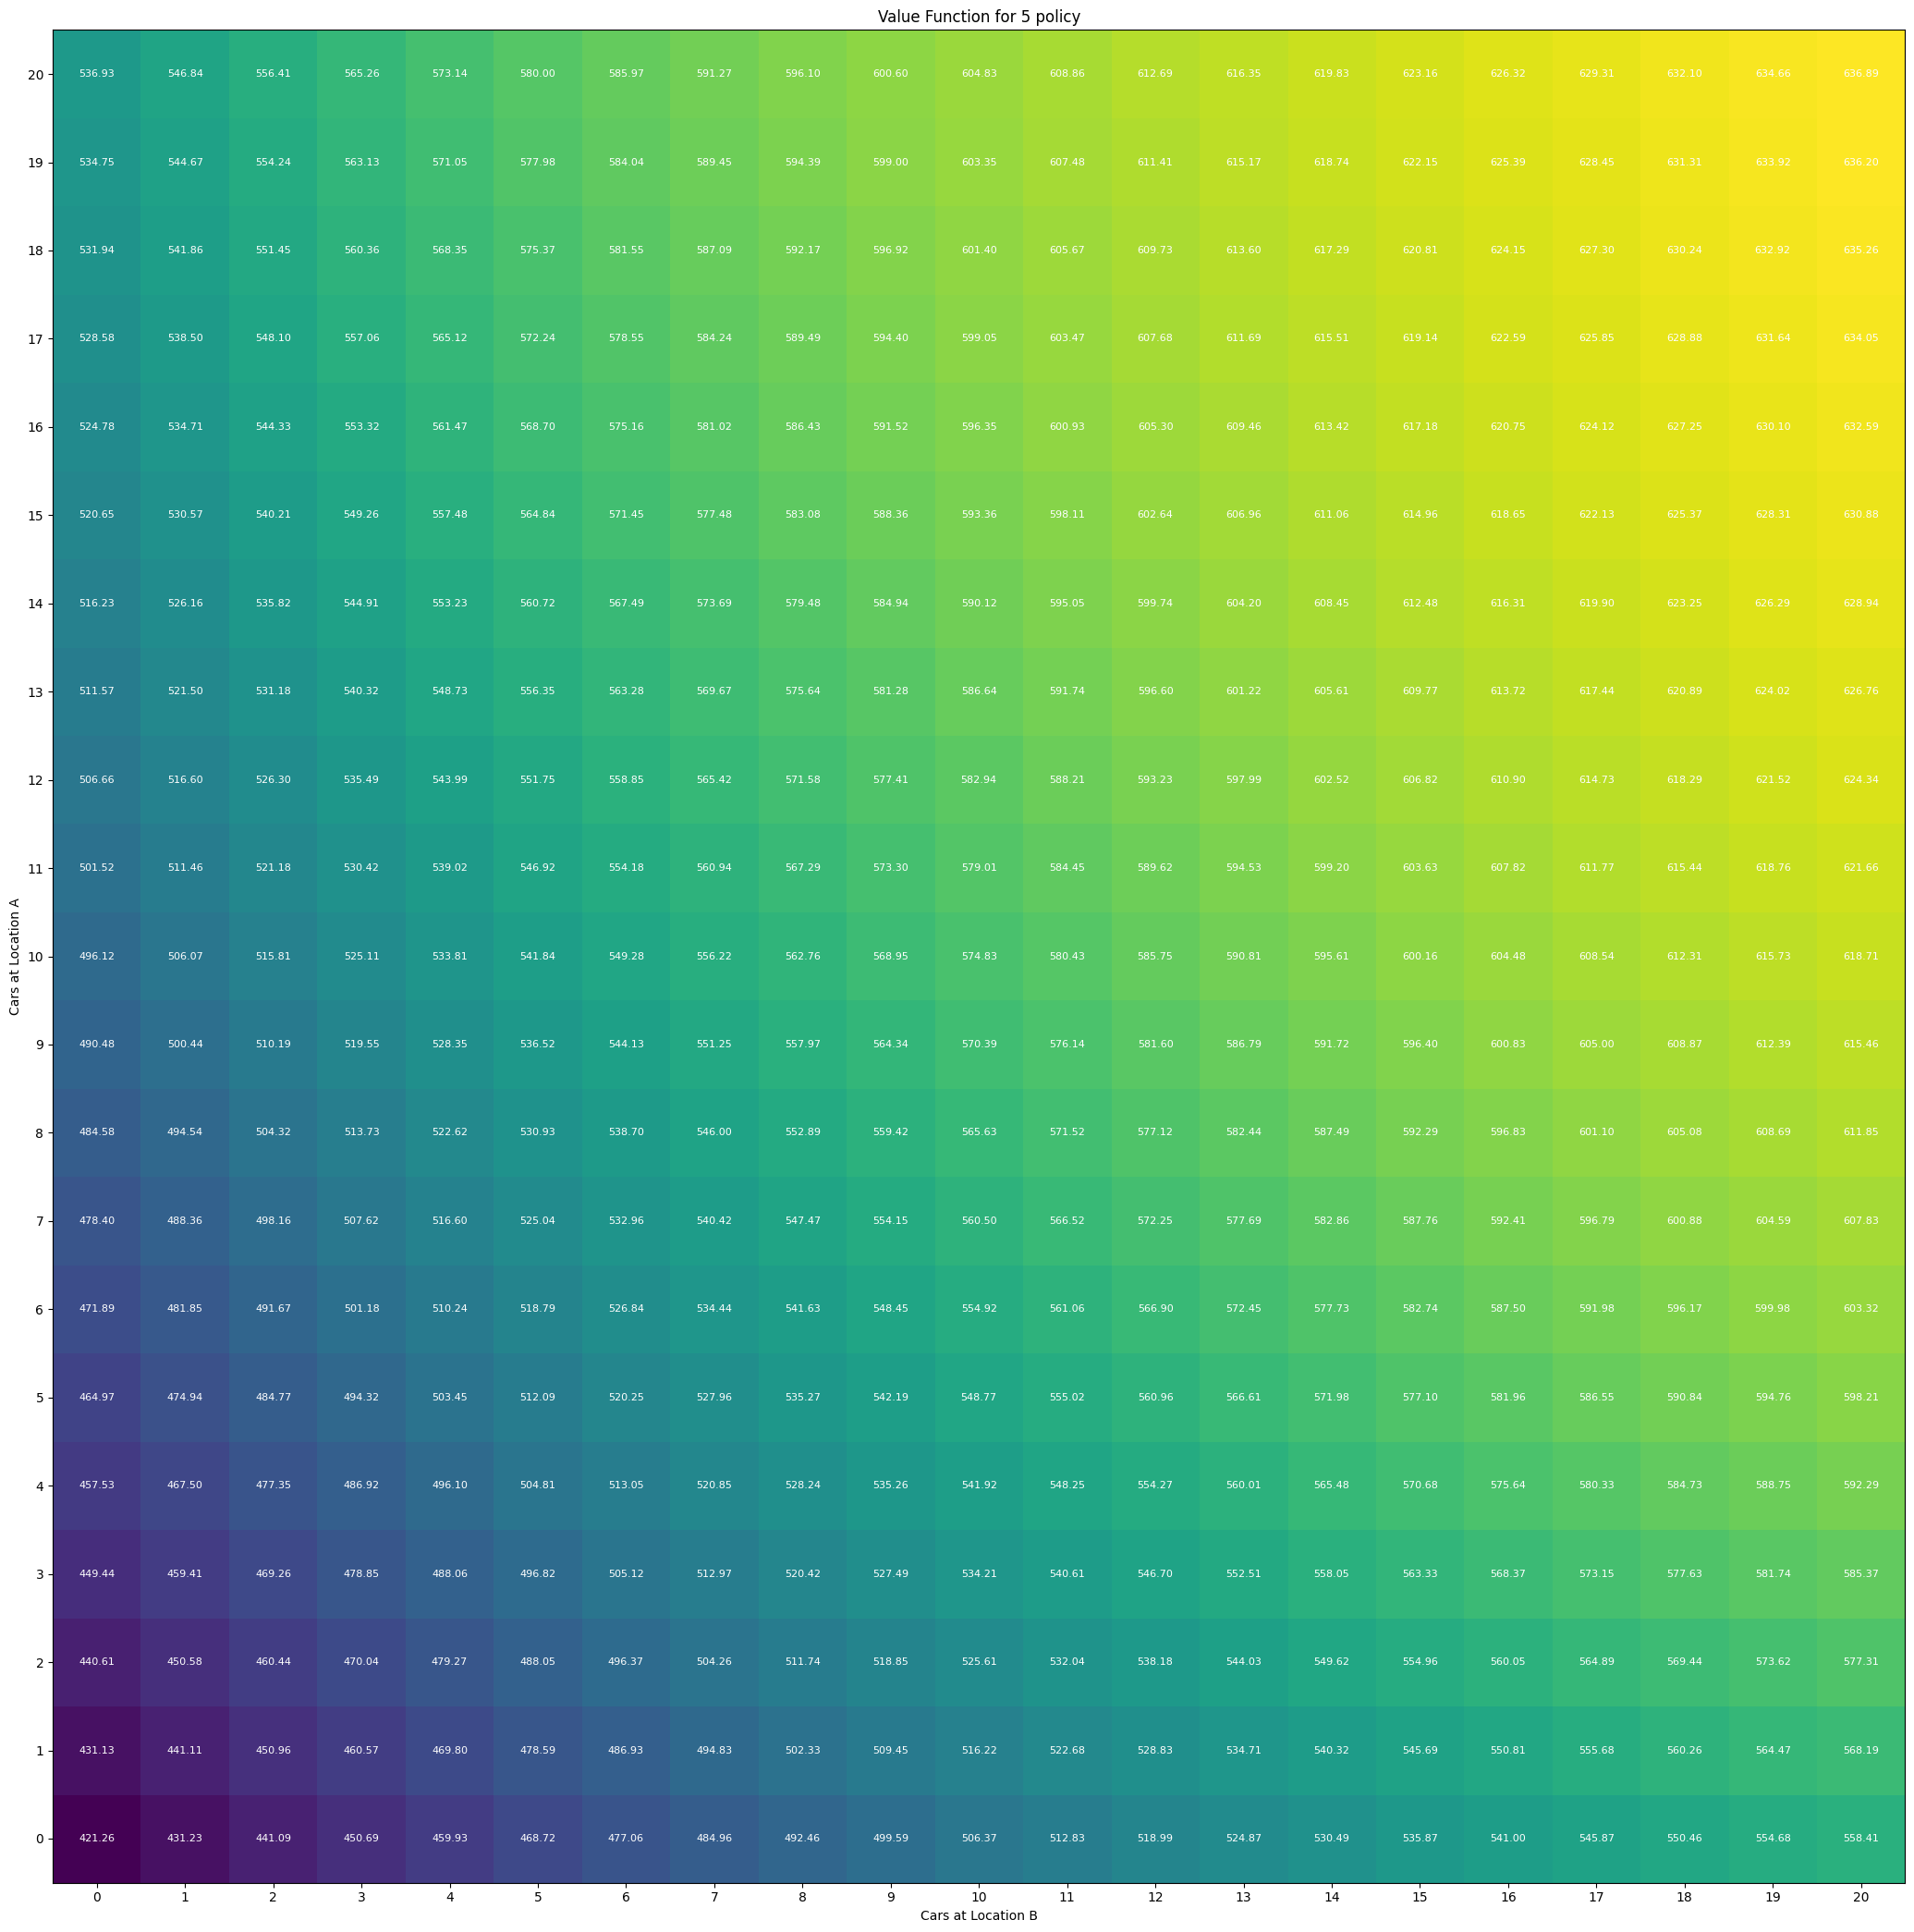

**********Staring 6 iteration


441it [00:00, 440926.83it/s]


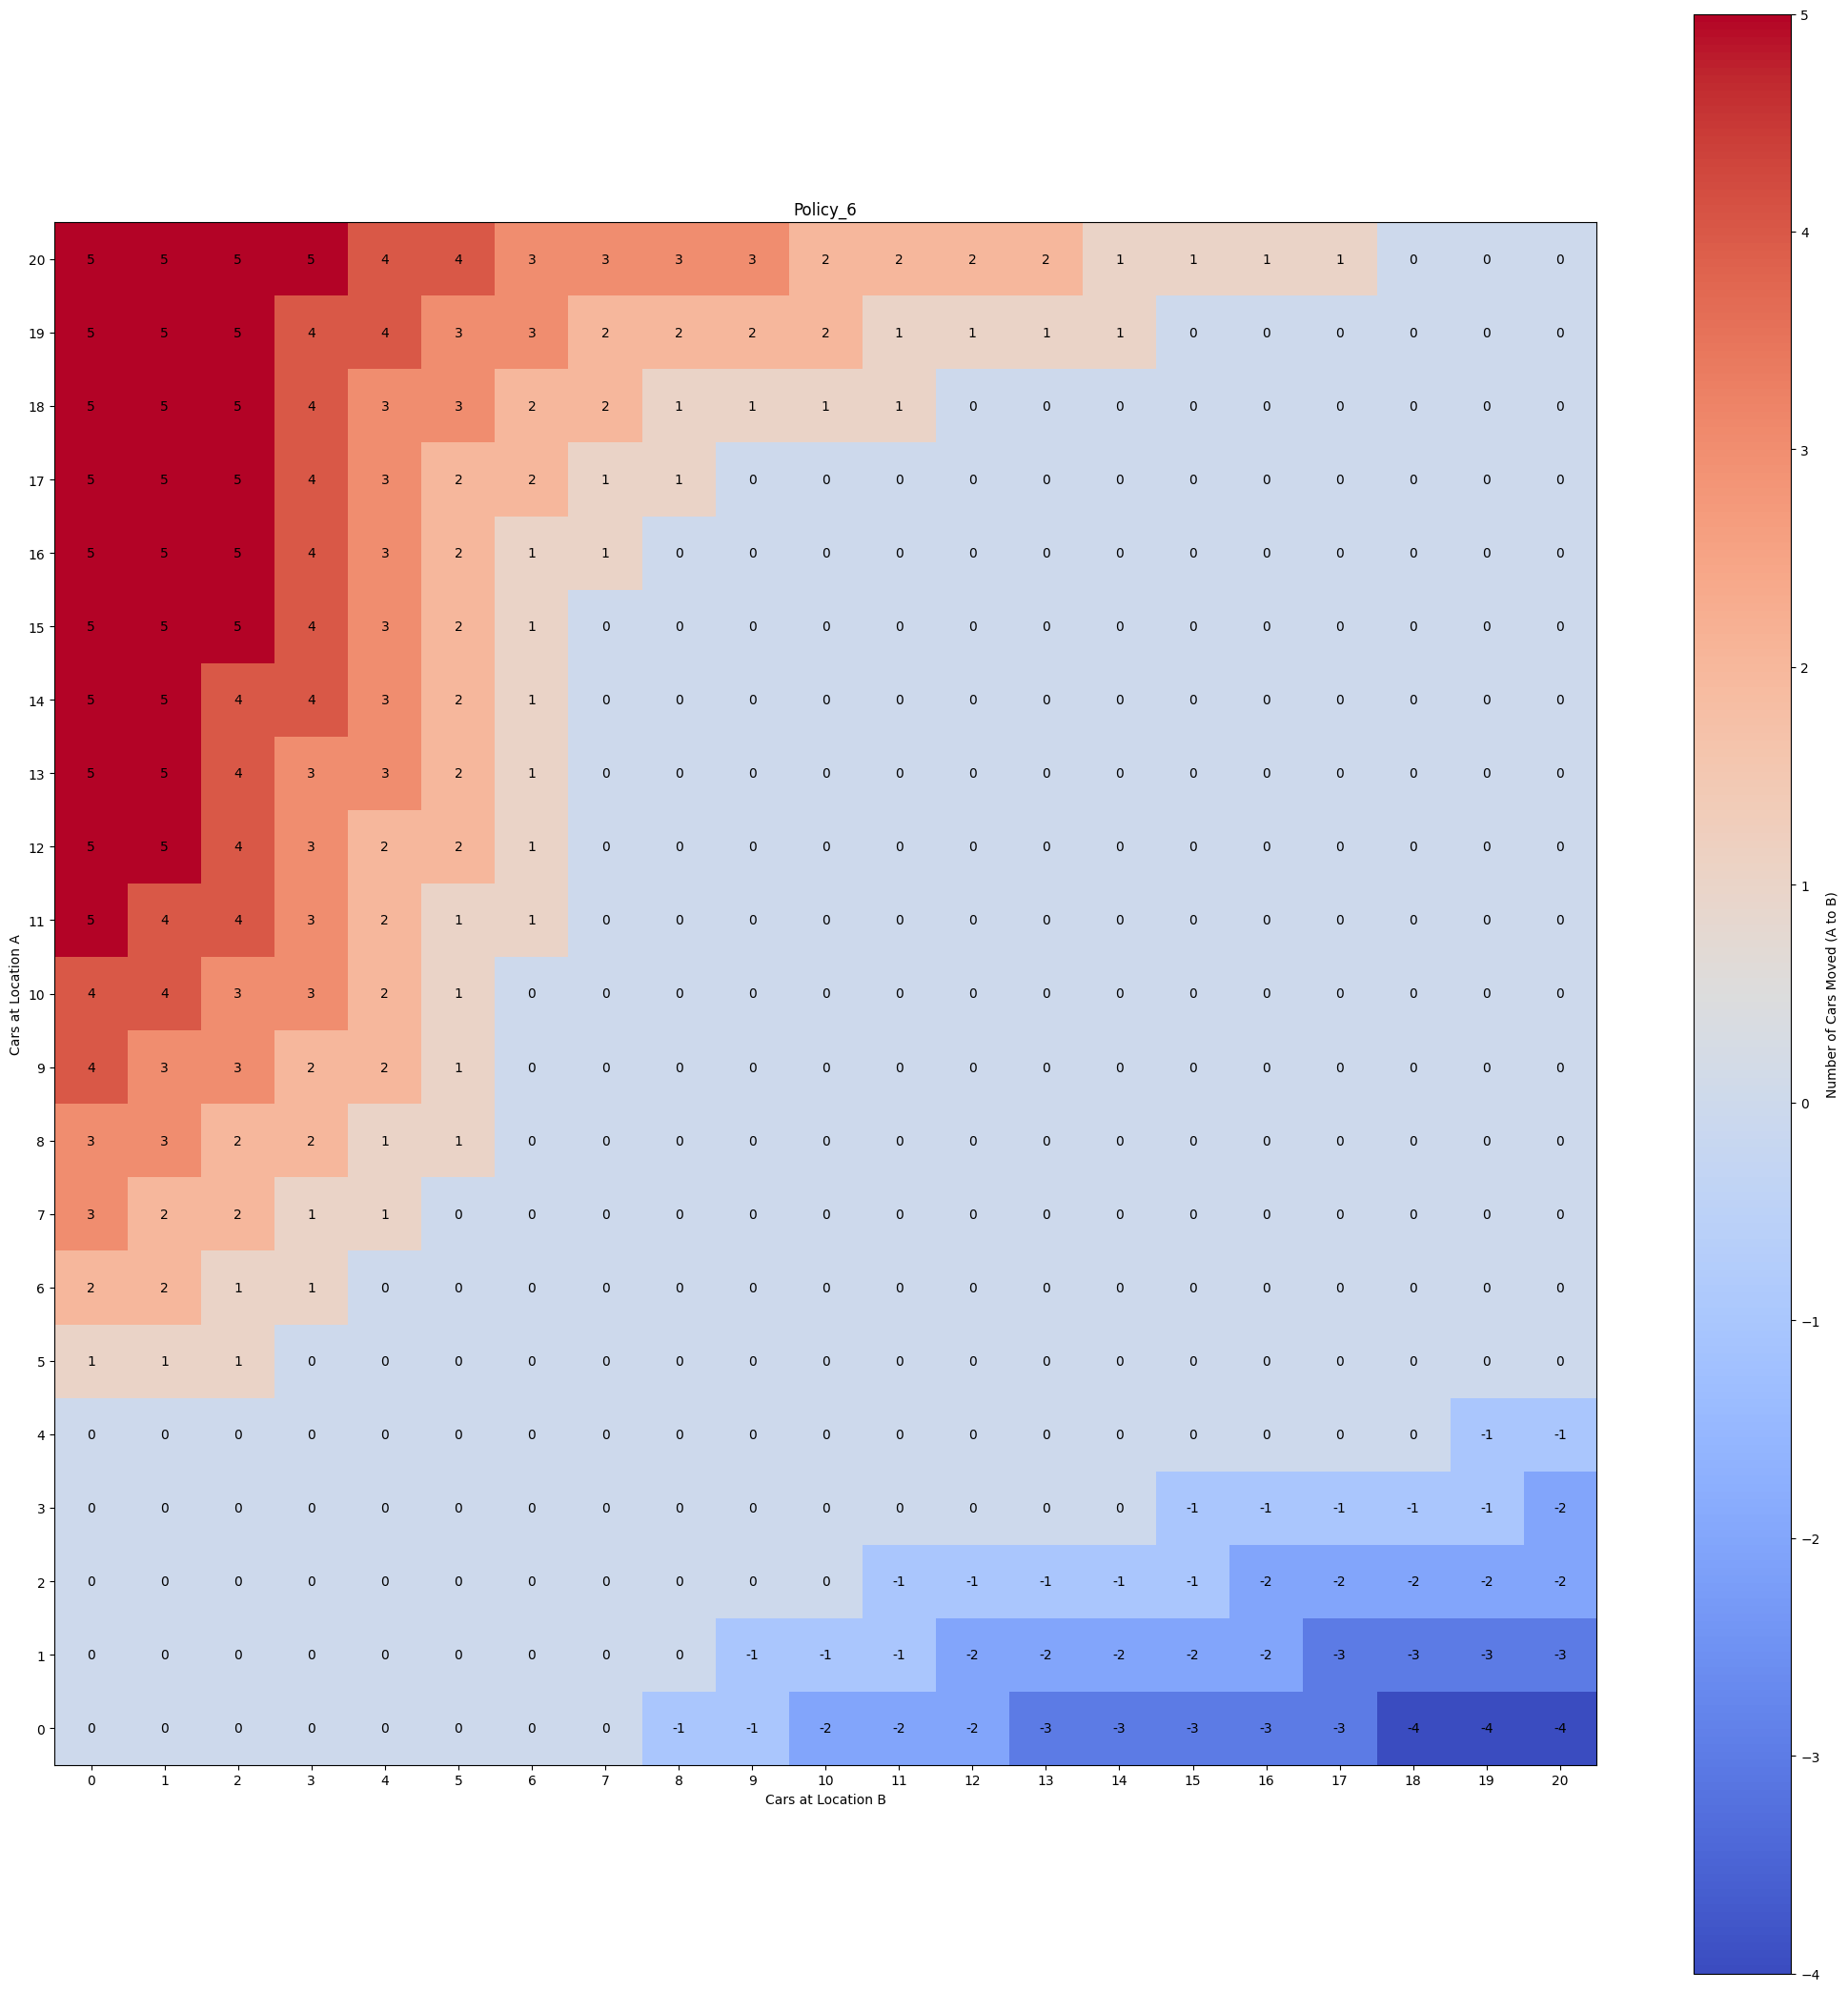

Policy reached optimal


In [9]:
agent = Agent()
policy_iteration_count = 0
print("Conduct initial Evaluation")
agent.evaluate()
while True:
    plot_value_table(agent.v_table, policy_iteration_count, CAPACITY_A, CAPACITY_B)
    policy_iteration_count += 1
    print('*' * 10 + f"Staring {policy_iteration_count} iteration")
    policy_stable = True
    for i, j in tqdm(itertools.product(range(CAPACITY_A + 1), range(CAPACITY_B + 1))):
        old_action = agent.policy[(i, j)]
        # we need to get all action value of this state and select the maximum action value as the new policy
        action_range = range(max(-j, i - CAPACITY_A, -agent.max_action), min(i, CAPACITY_B - j, agent.max_action) + 1)
        state = (i, j)
        q_values = {}
        for action in action_range:
            action_value = 0.0
            s_a = i - action
            s_b = j + action
            afterstate = (s_a, s_b)
            afterstate_value = agent.v_table[afterstate]
            action_value = afterstate_value - 2.0 * abs(action)
            q_values[(i, j, action)] = action_value
        
        max_action = max(q_values, key=q_values.get)[2]
        agent.policy[(i, j)] = max_action
        if old_action != max_action:
            policy_stable = False

    plot_policy(agent.policy, policy_iteration_count, CAPACITY_A, CAPACITY_B)
    if policy_stable:
        print('Policy reached optimal')
        break
    print(f"Conduct {policy_iteration_count} time evaluation")
    agent.evaluate()
